# Intuition behind the Longstaff-Schwartz implementation

- This sections draws significant inspiration from the excellent educational materials by **quantgirluk** - [Understanding Quantitative Finance](https://quantgirluk.github.io/Understanding-Quantitative-Finance/AOS.html), whose clear exposition of the Longstaff-Schwartz algorithm provided valuable implementation insights and visualization approaches.


## Geometric Brownian Motion
We will assume that the dynamics of the prices of the underlying asset follows GBM. That is to say, that the Itô process $\{X_t\}_{t\in\mathbb{N}}$ satisfies the following stochastic differential equation (SDE)

$$ \mathrm{d}X_t = rX_t \, \mathrm{d}t + \sigma X_t \, \mathrm{d}W_t   $$

with $X_0 = x_0 > 0$, where $W_t$ denotes a standard Brownian motion, and $r, \sigma$ are known parameters.

In [ ]:
# Import libraries
import numpy as np
from aleatory.processes import GBM
from aleatory.utils.plotters import draw_paths

import matplotlib.pyplot as plt

from aleatory.styles import qp_style

qp_style()  # Use quant-pastel-style

%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
my_style = "https://raw.githubusercontent.com/quantgirluk/matplotlib-stylesheets/main/quant-pastel-light.mplstyle"
plt.style.use(my_style)
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["figure.dpi"] = 100


## Parameters
- $r = 2\%$,
- $\sigma = 15\%$,
- $x_0 = 1.0$,
- Maturity $T=6$ (6 months),
- $N=50$ - simulating $50$ paths on the grid,
- $n=120$ - simulating $120$ time-steps (points) [20 days per month].

In [1]:
r = 0.02
sigma = 0.15
x0 = 1.0
T = 6
N = 50 # Number of paths
n = 20*6 # Number of steps
gbm = GBM(initial=x0, drift=r, volatility=sigma, T=T)
paths = gbm.simulate(n=n, N=N) # n steps, N paths

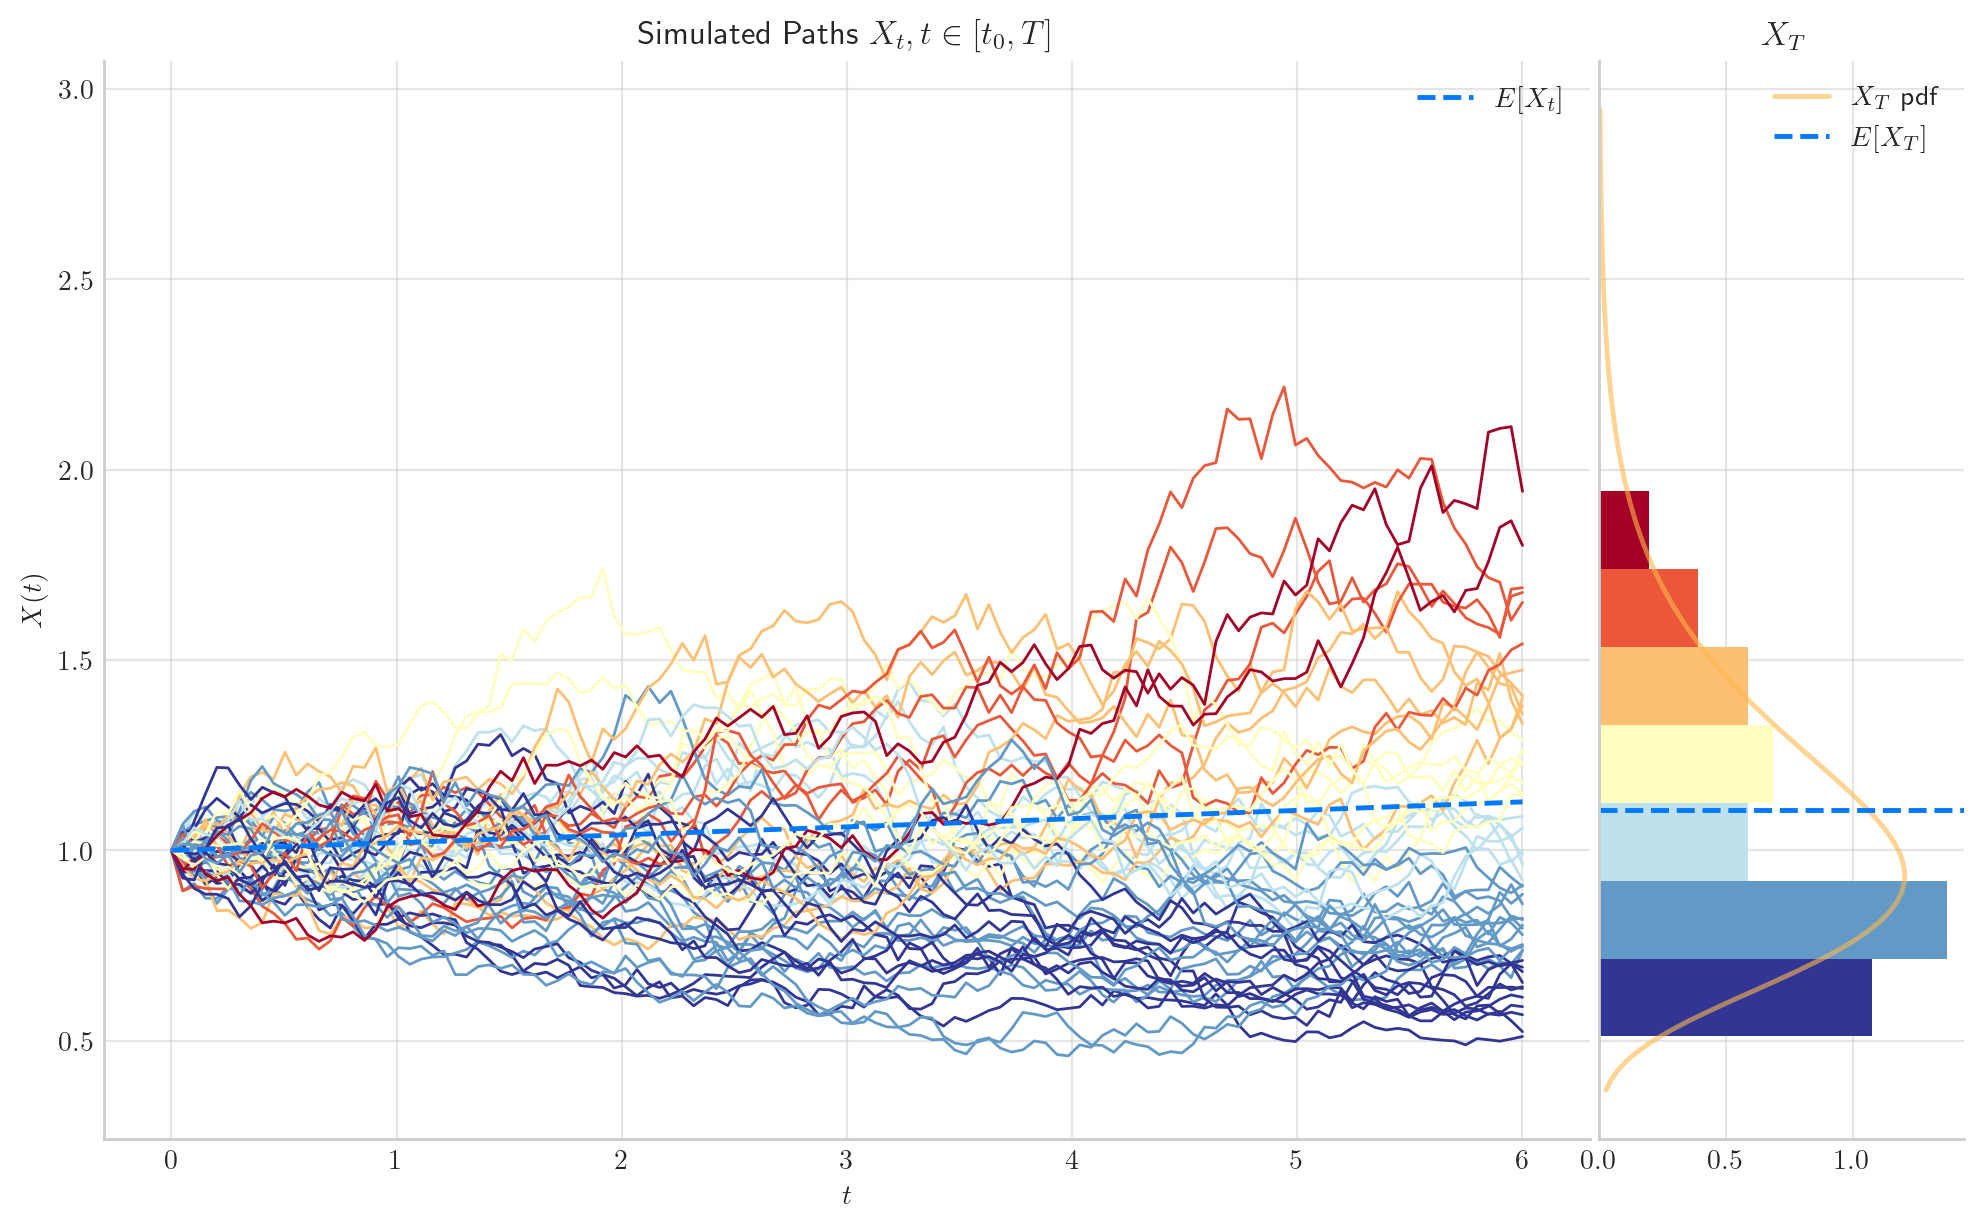

In [2]:
times = gbm.times
expectations = gbm.marginal_expectation(times)
marginalT = gbm.get_marginal(5.0)
X = np.stack(paths, axis=1)
draw_paths(times=times, paths=paths, N=N, expectations=expectations, marginalT=marginalT, marginal=True)
plt.show()

## American Option Contracts 
- $S_0 = 1.0$ Initial stock price
- We consider American put contract as a **writter/seller**.
- The **holder/buyer** has the right to exercise the option at any time between today (time $t_0 = 0$) and maturity $t_n = T = 6$.
- If the *holder* decides to exercise at time $t_i$, this means that he will **sell** the asset (whose market price os $X_{t_i}$ at time $t = t_i$) at price $K = 1.1 to us (*writer*).
- Why put? Assuming no dividends are being paid, **only** for the put option it is sometimes optimal to exercise earlier.
    - Why? Suppose we have a American call at time $t < T$ with the payoff $[X_t - K]^+$.
        - Alternative strategy: the option holder may short the underlying asset (which gives the payoff $S_t$), and purchsae the asset by the most favourable of 
            - exercise the American call at maturity, and
            - buying at the market price at time $T$.
        - With the alternative strategy the holder has gained amount $S_t$ at time $t$ and paid out an amount $\leq K$ at time $T$. 
        This is clearly, better than gaining the different $X_t - K$ at time $t$.
        - Hence *it is never optimal to exercise an American call option before the expiry date*.
        - American call option must have the same value as a European call option, i.e. $C^{AM} = C^{EU}$.
- For a **put option**, early exercise **can be optimal**, because:
    - You can receive  $[K - X_t]$ earlier and invest it,
    - If the option is deep in the money (i.e., $S_t \ll K$) and interest rates are positive, early exercise may dominate holding,
    - Hence: $P^{AM} \geq P^{EU}$, and strict inequality is possible
    

In [3]:
K = 1.1

## Discretisation of the domain
- If $S_{t_i} \geq K$, then the holder has **no** incentive to exercise the option (i.e. selling the asset at price $K$ makes no sense!)
- If $S_{t_i} < K$, then the option is In-The-Money (ITM) and rhe holder **may want to exercise** it. The payoff in case of exercise at time $t_i$ would be $Y(t_i) = [K- S_{t_i}]^+$

Let us visualise the times when the simulated paths have a positive payoff.

/var/folders/1p/dh14fkh53hddc1l6713y6pmm0000gn/T/ipykernel_44717/4100275644.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


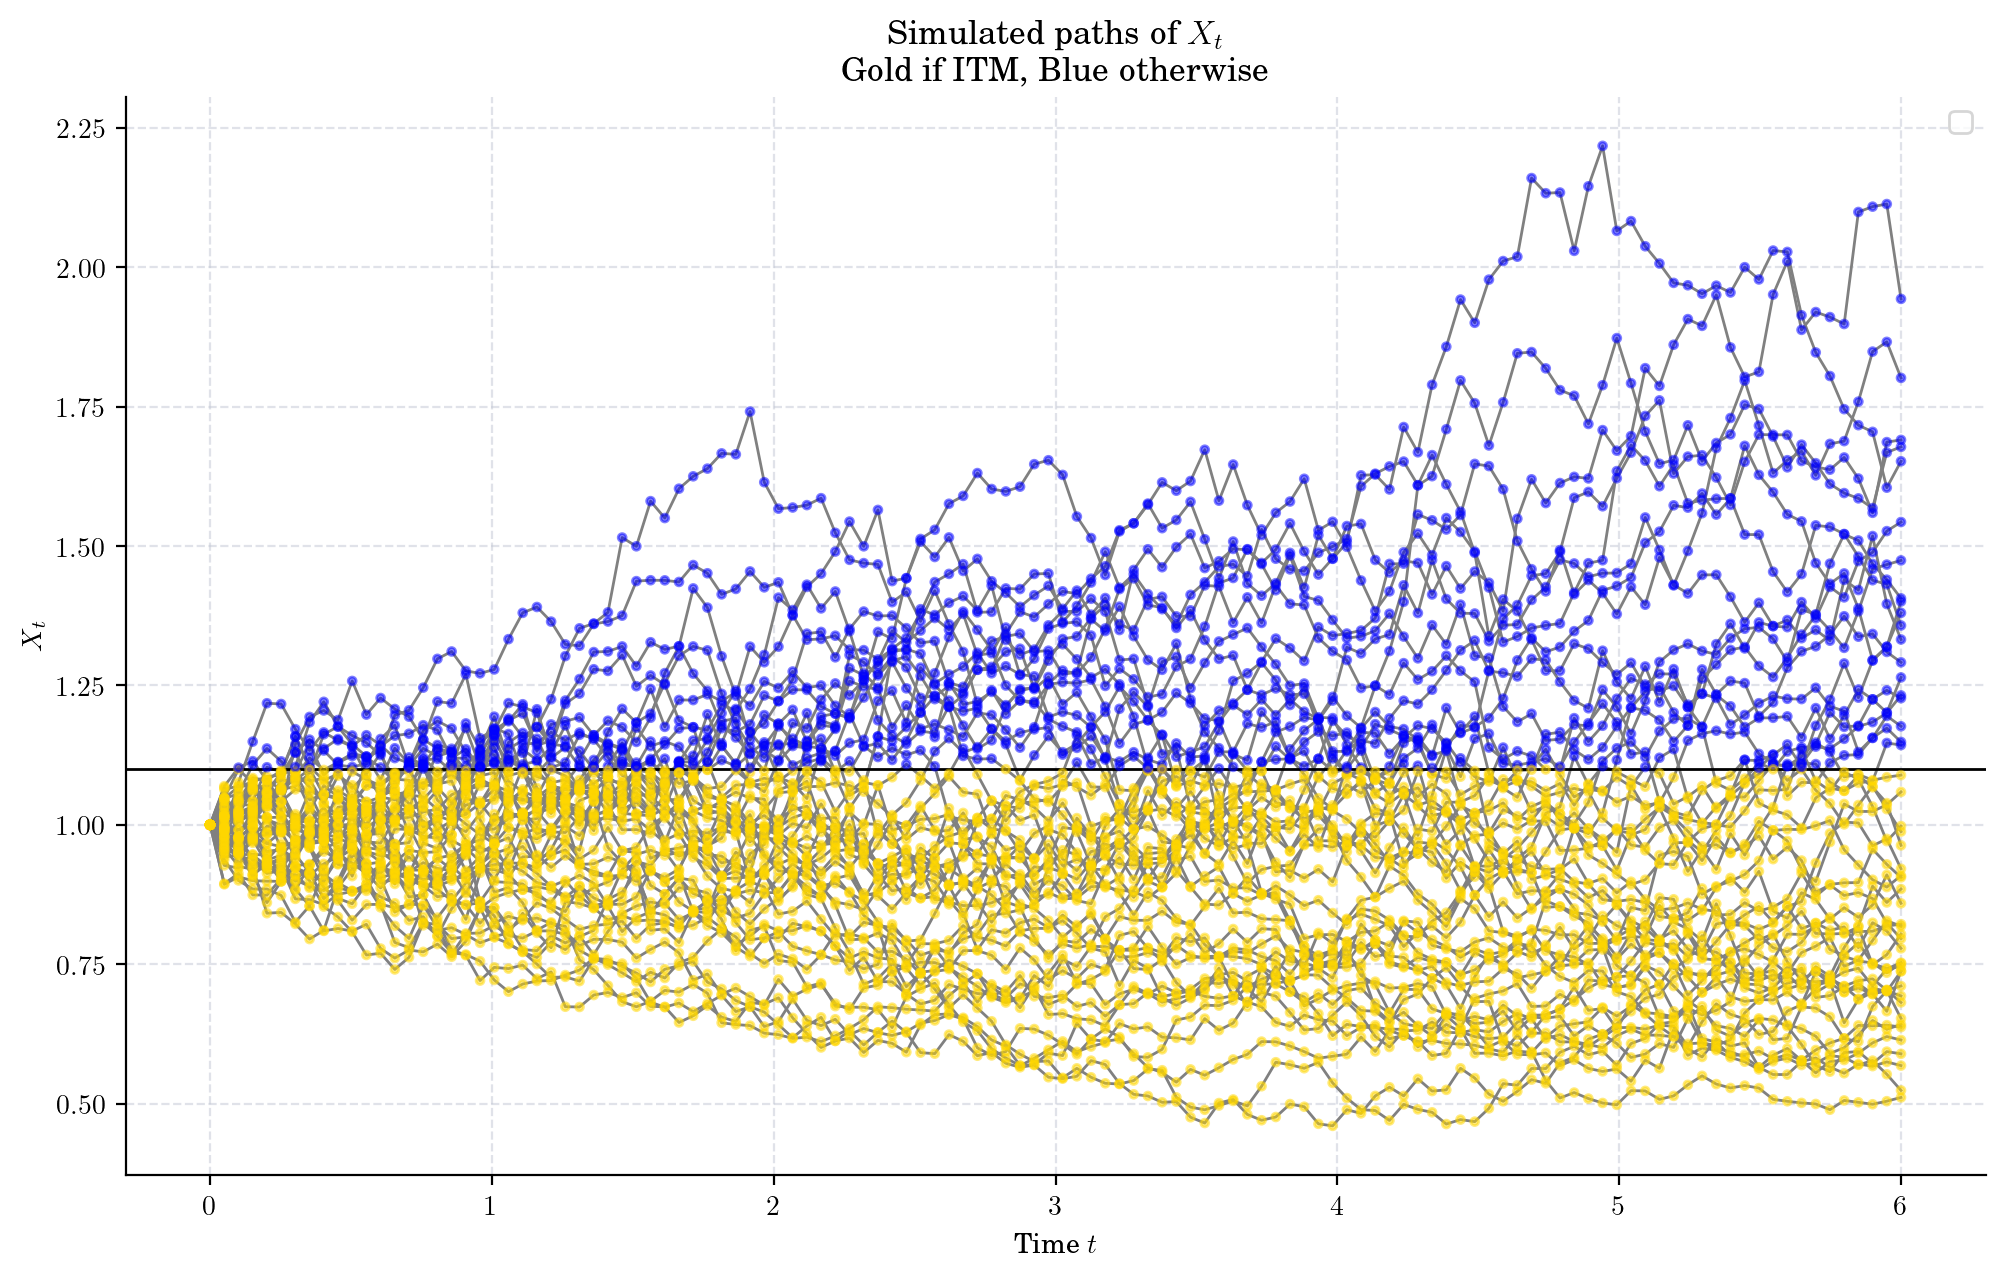

In [4]:
for path in paths:
    colors = ['gold' if (x<K) else 'blue' for x in path]
    plt.plot(times, path, color="gray")
    plt.scatter(times, path, c=colors, s=8, zorder=3, alpha=0.5)
plt.title("Simulated paths of $X_t$\n Gold if ITM, Blue otherwise")
plt.axhline(K, color="black", linewidth=1)
plt.xlabel("Time $t$")
plt.ylabel("$X_t$")
plt.legend()
plt.show()

Next, we define the payoff function, recall $[K- S_t]^+ = \max\{(K-S_t, 0)\}$.


In [5]:
def exercise_value(x):
    return np.maximum(K - x, 0)

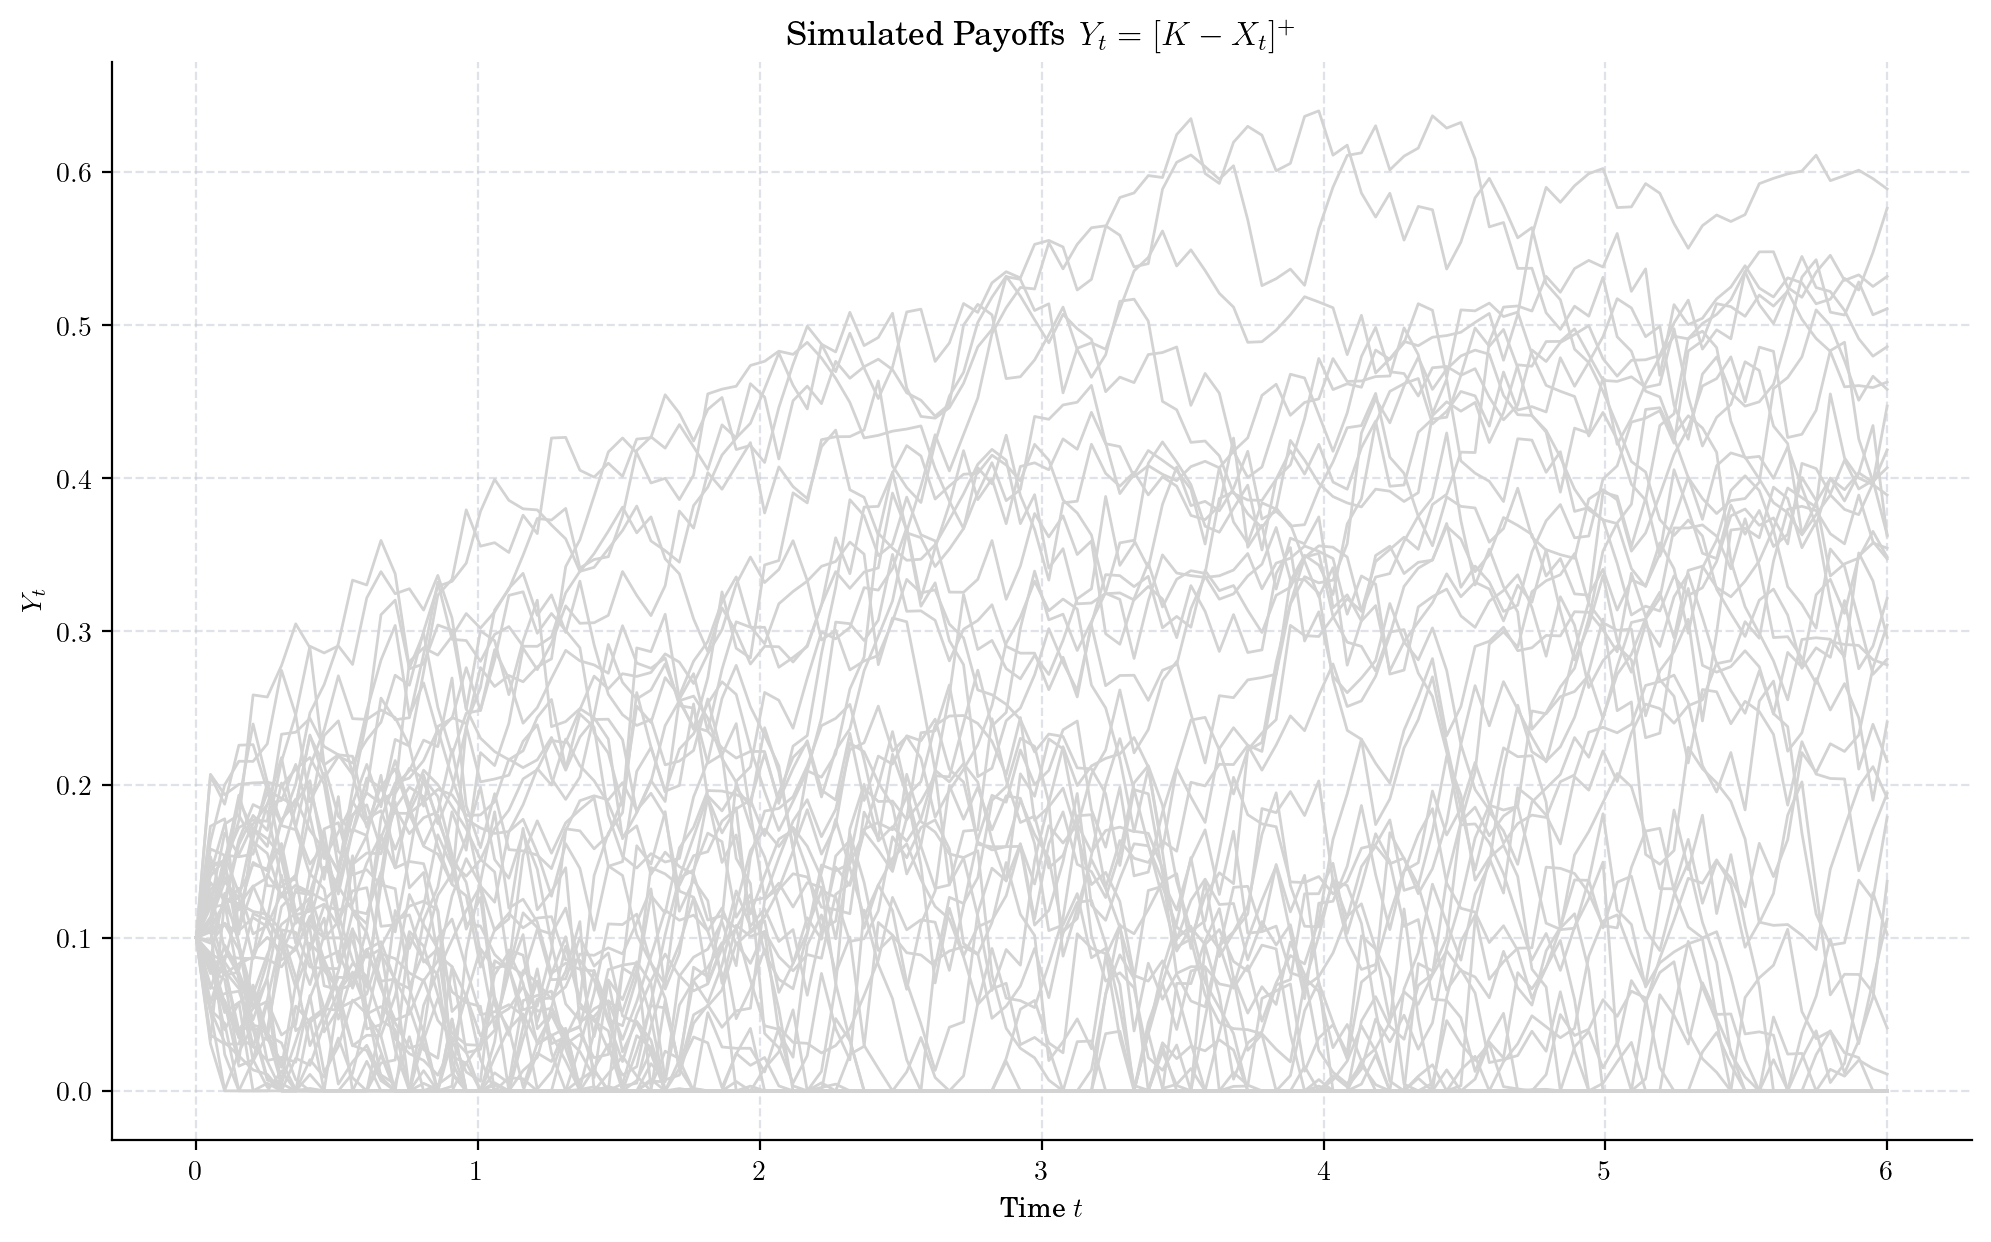

In [6]:
for path in paths:
    plt.plot(times, exercise_value(path), color="lightgrey")
plt.title("Simulated Payoffs\, $Y_t = [K- X_t]^+$")
plt.ylabel("$Y_t$")
plt.xlabel("Time $t$")
plt.show()

So, at every time $t_i$, the holder has the right to exercise the option to obtain the payoff,
$$ \textrm{Exercise Value} = Y(t_i) = [K - S_{t_i}]^+. $$

Now, the problem is that we do not know if its better to exercise or hold (continue to $t_{i+1}). For this we need to ***estimate continuation value***, that is we need to look one step into the and compare (immediate) exercise value vs. continuation value.

So, how do we estimate continuation value?
$$ \textrm{Continuation Value} = C(t_i) = \, \textrm{?} $$


## To exercise or not to exercise - Longstaff-Schwartz Algorithm
- Why is the Monte Carlo computationally infeasible? 
    - For a fixed $\omega$-path, at each node, we need to decide whether to exercise the option or not, whereas the continuation value is not known without either embedding another MC simulation at each node of each time lattice or a prior exercise strategy, since
    $$ C(x, t_{n-1}) = e^{-r\Delta t}\mathbb{E}[V(X_{t_n}, t_n) \mid X_{t_{n-1}} = x] $$
    $$ V(x, t_{n-1}) = \max\{ \Lambda(x, t_{n-1}, \, C(x, t_{n-1})  \} $$


- In order to estimate continuation value, we follow the approach by Longstaff-Schwartz. 

- The demonstration by [Dr D. Santiago's book](https://quantgirluk.github.io/Understanding-Quantitative-Finance/AOS.html) provides great intuition.


First, lets plot the discounted cashflows.

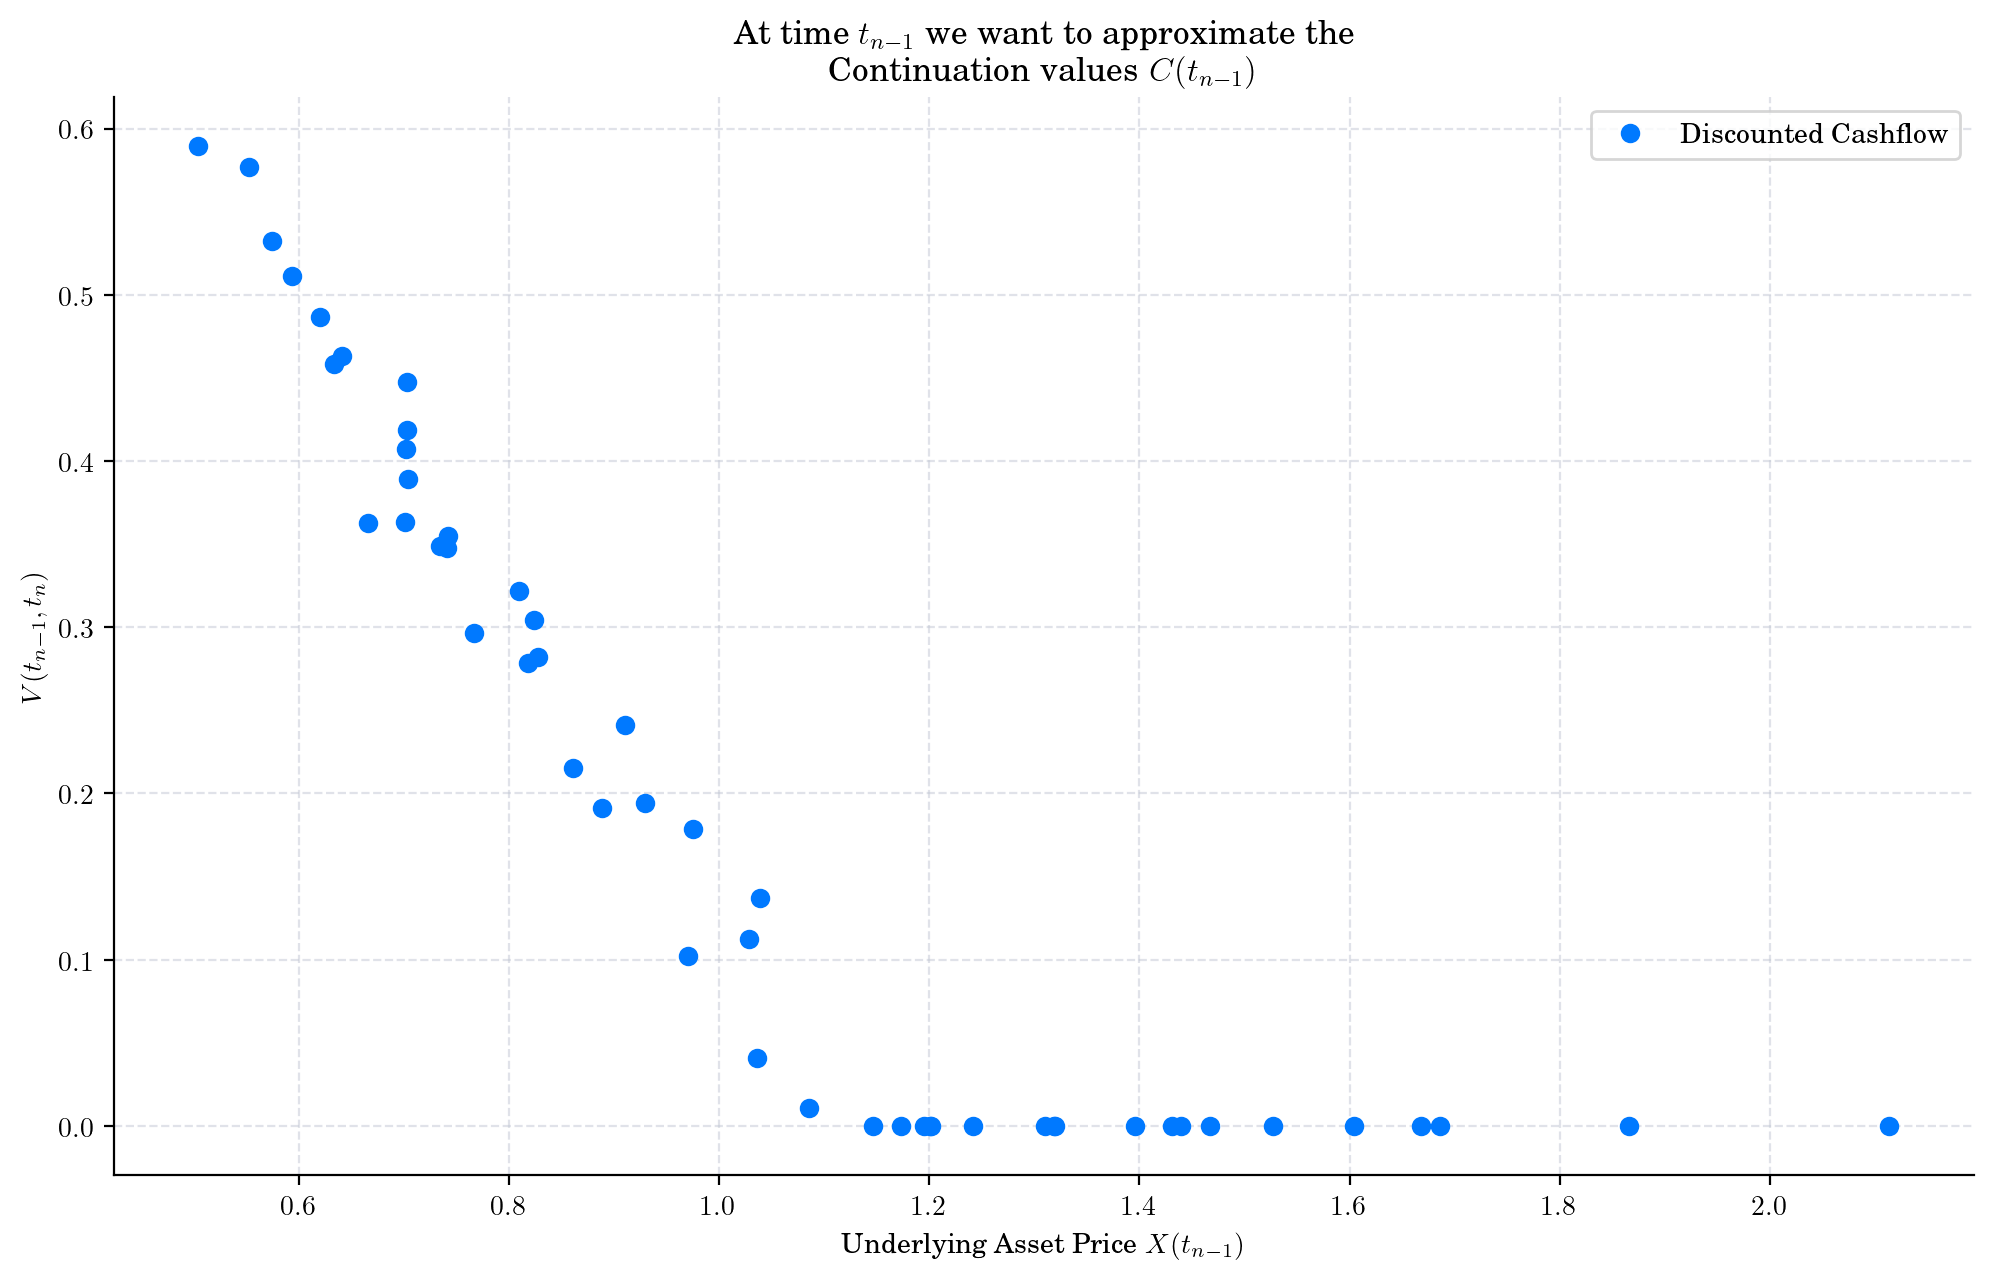

In [7]:
cashflow = np.exp(-r * (times[-2] - times[-1])) * exercise_value(X[-1, :]) 
x = X[-2, :]
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow")
plt.ylabel("$V(t_{n-1}, t_n)$")
plt.xlabel("Underlying Asset Price $X(t_{n-1})$")
plt.title("At time $t_{n-1}$ we want to approximate the \nContinuation values $C(t_{n-1})$")
plt.legend()
plt.show()

Second, in order to estimate the continuation value (or, the conditional expectation), the Longstaff-Schwartz implementation makes use of least-squares method to fit a polynomial function to the pairs 

$$ (X(t_{n-1}, \omega), \, V(t_{n-1}, \omega))$$

and then using such polynomials to approximate the continuation value as 

$$ C(t_{n-1}) \approx \sum_{j=0}^{\infty} \hat{\alpha}_{ij}L_j(X(t_{i})) $$ 

- So the question is, what if we could do approximation with simple functions (basis functions) multiplied with some weights?

So, we need to make two choices:
1 Polynomial functions e.g. Laguerre (used in paper), Hermite, Chebyshev, Jacobiused as basis functions.
2 Degree of the Polynomial.

### Laguerre Polynomials (paper)

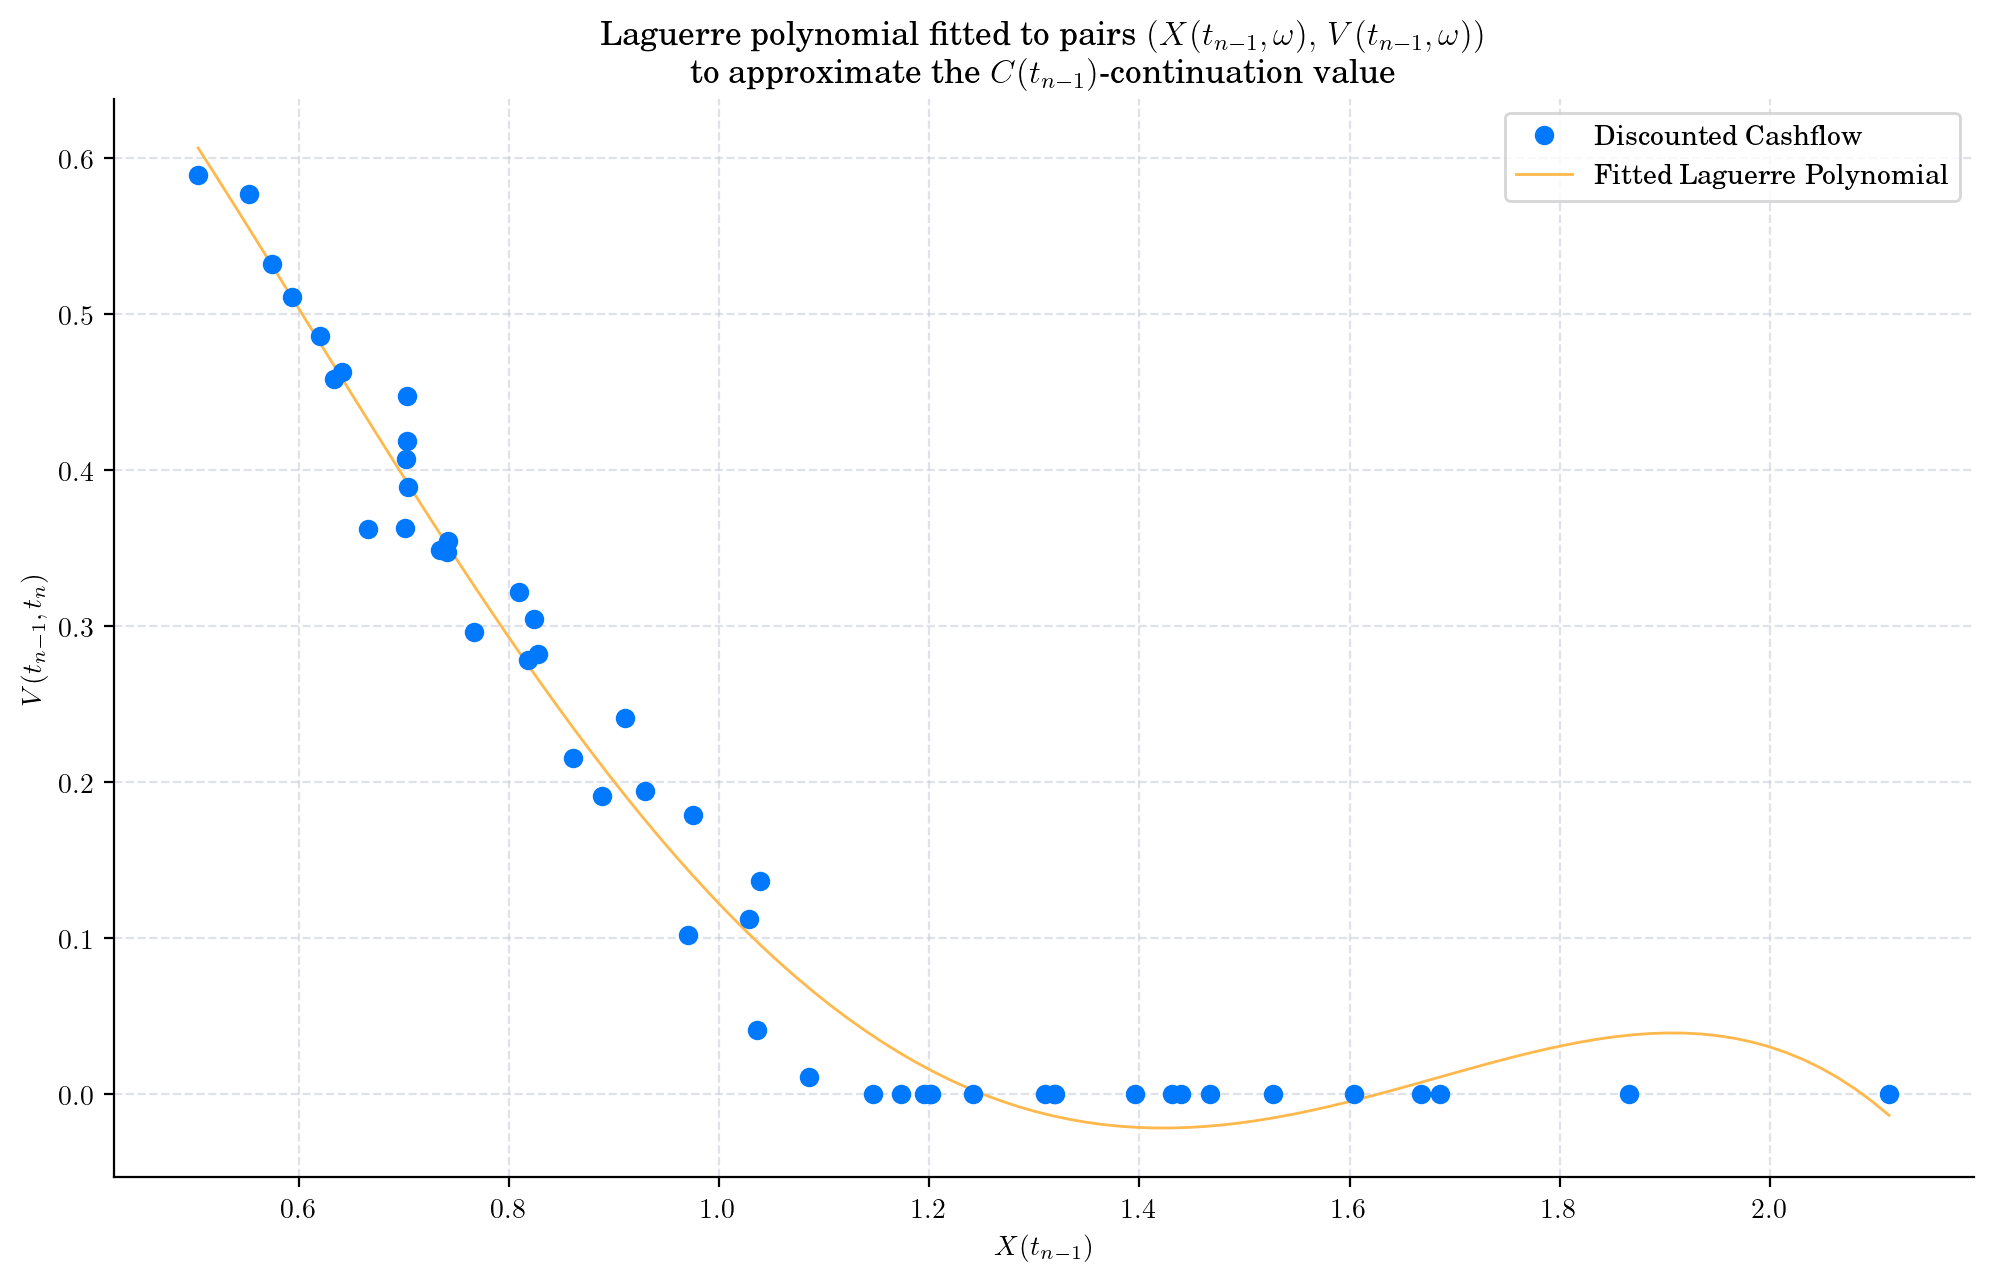

In [8]:
cashflow = np.exp(-r * (times[-2] - times[-1])) * exercise_value(X[-1, :]) 
x = X[-2, :]
# Laguerre polynomial
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow", zorder=3)

# Fit the Laguerre polynomials
fitted_laguerre = np.polynomial.Laguerre.fit(x, cashflow, 4)

plt.plot(*fitted_laguerre.linspace(), label="Fitted Laguerre Polynomial")

plt.title("Laguerre polynomial fitted to pairs $(X(t_{n-1}, \omega), \, V(t_{n-1}, \omega))$\n to approximate the $C(t_{n-1})$-continuation value")
plt.xlabel("$X(t_{n-1})$")
plt.ylabel("$V(t_{n-1}, t_n)$")
plt.legend()
plt.show()

Where the associated least-sqaures equation takes the following form:

In [9]:
fitted_laguerre

Laguerre([ -52.95181379,  238.31920177, -400.66133219,  298.90902217,
        -83.0084563 ], domain=[0.5043643 , 2.11321901], window=[0., 1.], symbol='x')

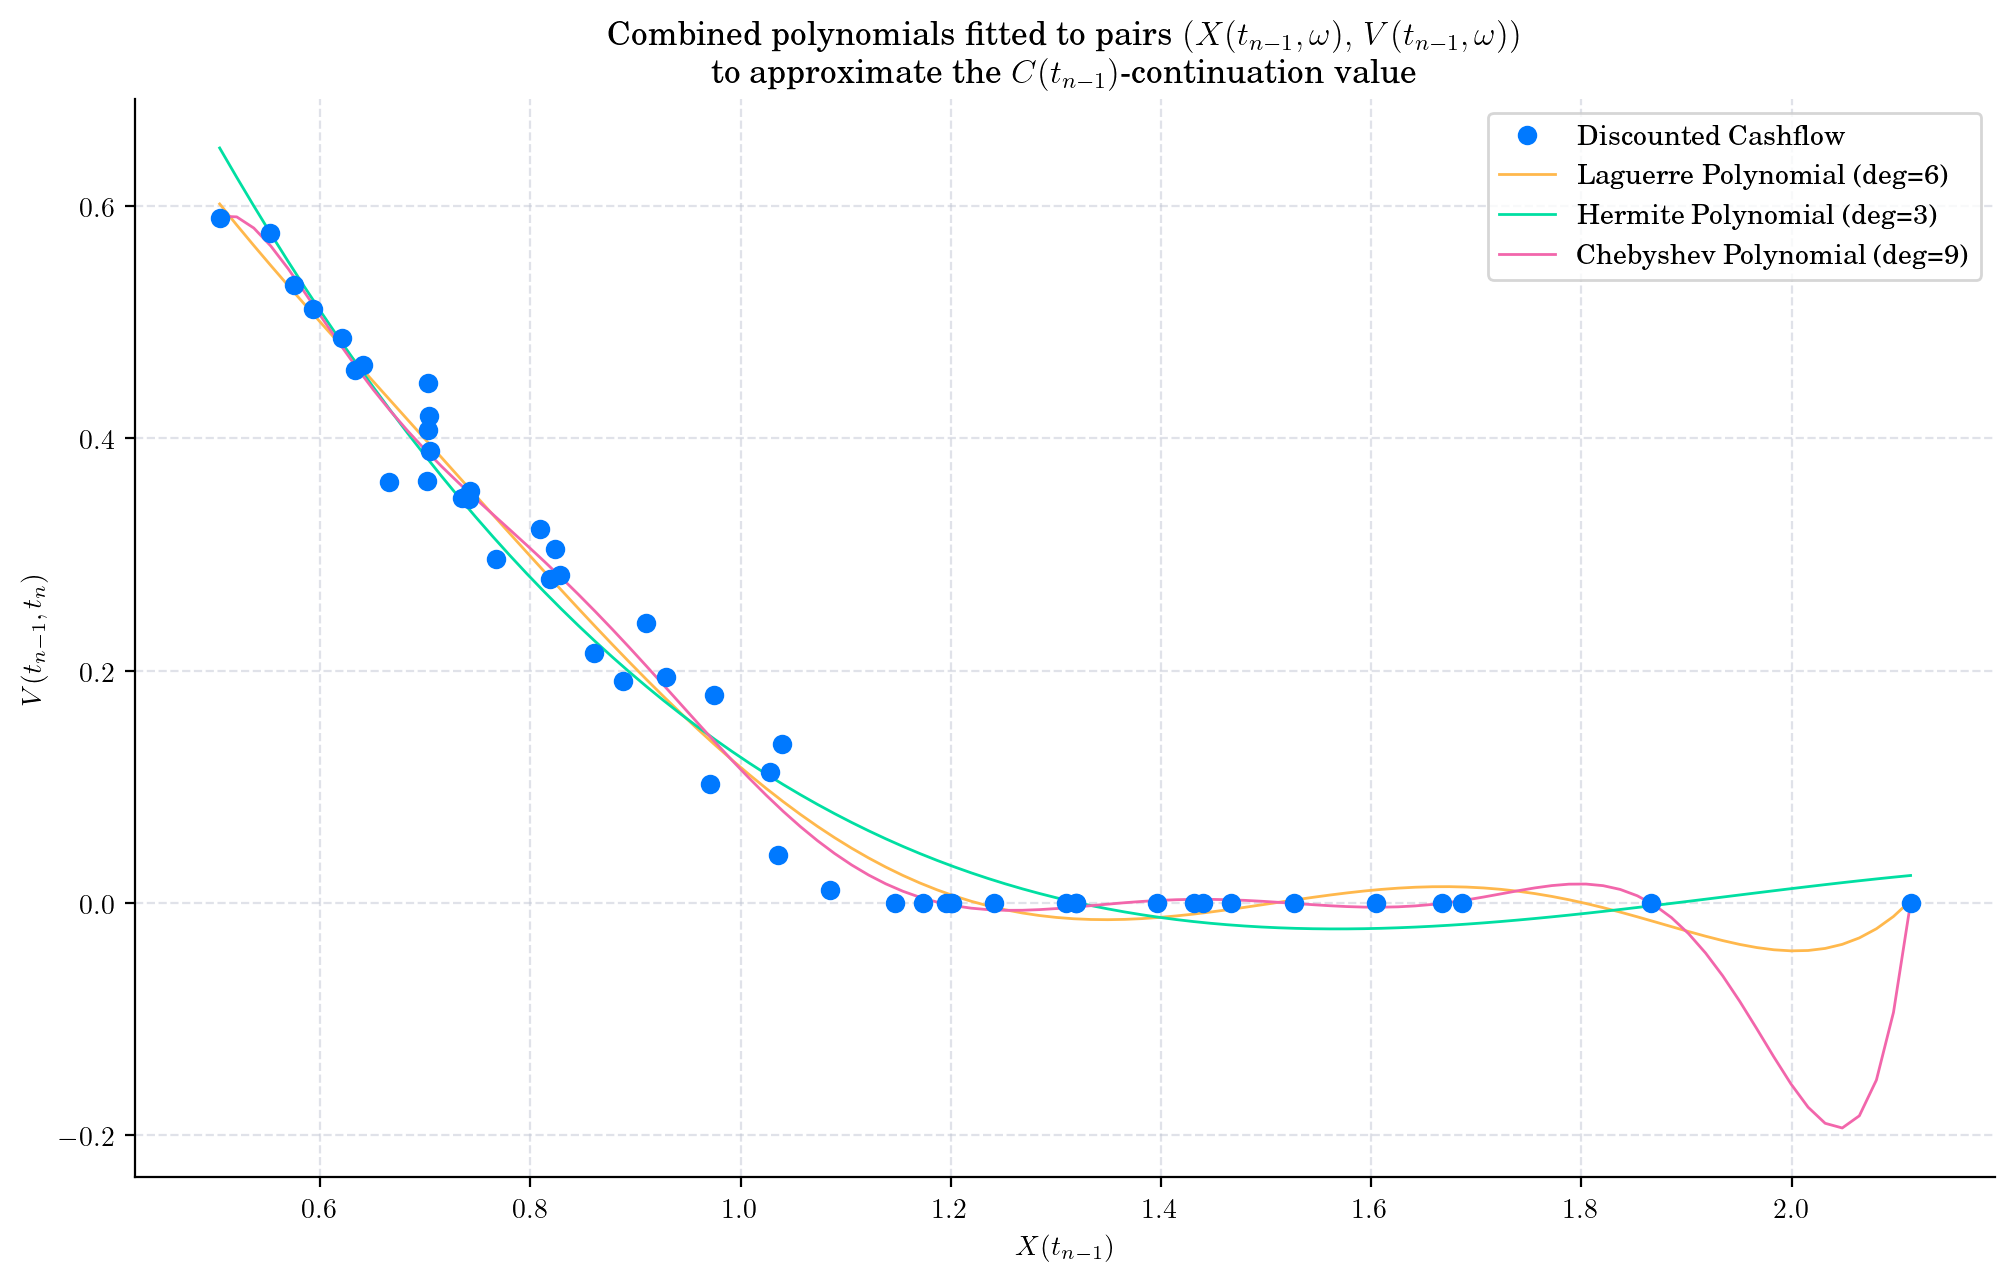

In [10]:
cashflow = np.exp(-r * (times[-2] - times[-1])) * exercise_value(X[-1, :]) 
x = X[-2, :]
# Combined polynomial
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow", zorder=3)

# Fit the Laguerre polynomials
fitted_laguerre = np.polynomial.Laguerre.fit(x, cashflow, 6)
fitted_hermite = np.polynomial.Hermite.fit(x, cashflow, 3)
fitted_chebyshev = np.polynomial.Chebyshev.fit(x, cashflow, 9)
plt.plot(*fitted_laguerre.linspace(), label="Laguerre Polynomial (deg=6)")
plt.plot(*fitted_hermite.linspace(), label="Hermite Polynomial  (deg=3)")
plt.plot(*fitted_chebyshev.linspace(), label="Chebyshev Polynomial  (deg=9)")
plt.title("Combined polynomials fitted to pairs $(X(t_{n-1}, \omega), \, V(t_{n-1}, \omega))$\n to approximate the $C(t_{n-1})$-continuation value")
plt.xlabel("$X(t_{n-1})$")
plt.ylabel("$V(t_{n-1}, t_n)$")
plt.legend()
plt.show()

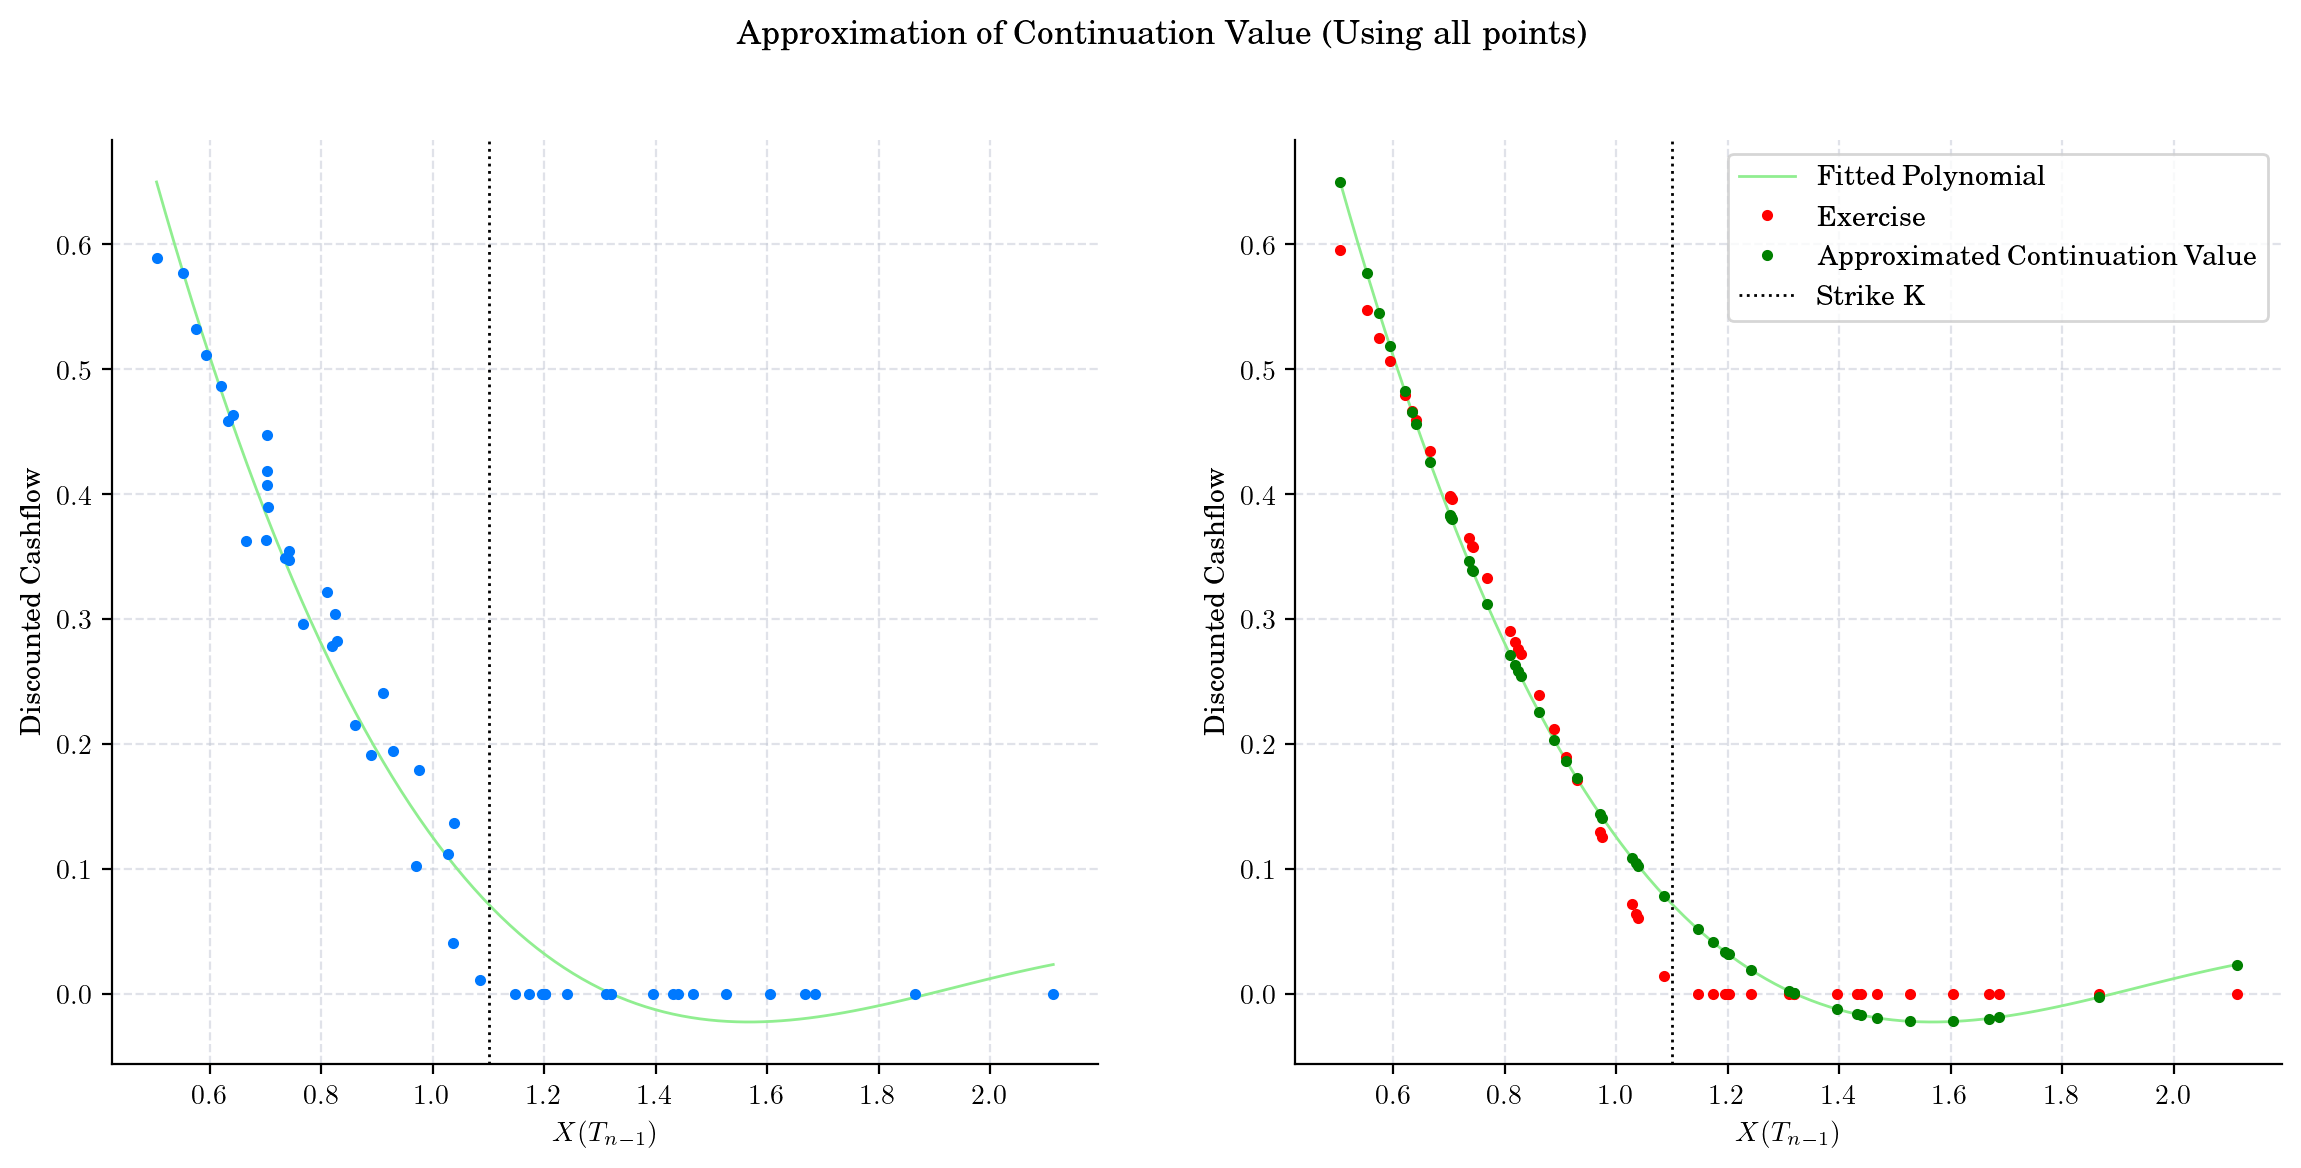

Polynomial([ 0.00252596, -0.17052688,  0.33421771, -0.14270267], domain=[0.5043643 , 2.11321901], window=[-1.,  1.], symbol='x')

In [11]:
cashflow = np.exp(-r * (times[-2] - times[-1])) * exercise_value(X[-1, :]) 
x = X[-2, :]
exercise = exercise_value(x)
fitted = np.polynomial.Polynomial.fit(x, cashflow, 3) # 3 degree as in paper

continuation = fitted(x)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(*fitted.linspace(), color="lightgreen", label="Fitted Polynomial")
axs[0].plot(x, cashflow, ".", zorder=3)
axs[0].axvline(x=K, linestyle=":", color="black", label="Strike K")
axs[0].set_xlabel("$X(T_{n-1})$")
axs[0].set_ylabel("Discounted Cashflow")

axs[1].plot(*fitted.linspace(), color="lightgreen", label="Fitted Polynomial")
axs[1].plot(x, exercise, ".", color="red", label="Exercise")
axs[1].plot(x, continuation, ".", color="green", label="Approximated Continuation Value")
axs[1].axvline(x=K, linestyle=":", color="black", label="Strike K")
axs[1].set_xlabel("$X(T_{n-1})$")
axs[1].set_ylabel("Discounted Cashflow")

fig.suptitle("Approximation of Continuation Value (Using all points)")
# fig.supxlabel("$X(T_{n-1})$")
# fig.supylabel("Discounted Cashflow")

plt.legend()
plt.show()
fitted # return the equation

Now, we focus on only ITM points, i.e. the paths which ended up with non-zero payoff. 

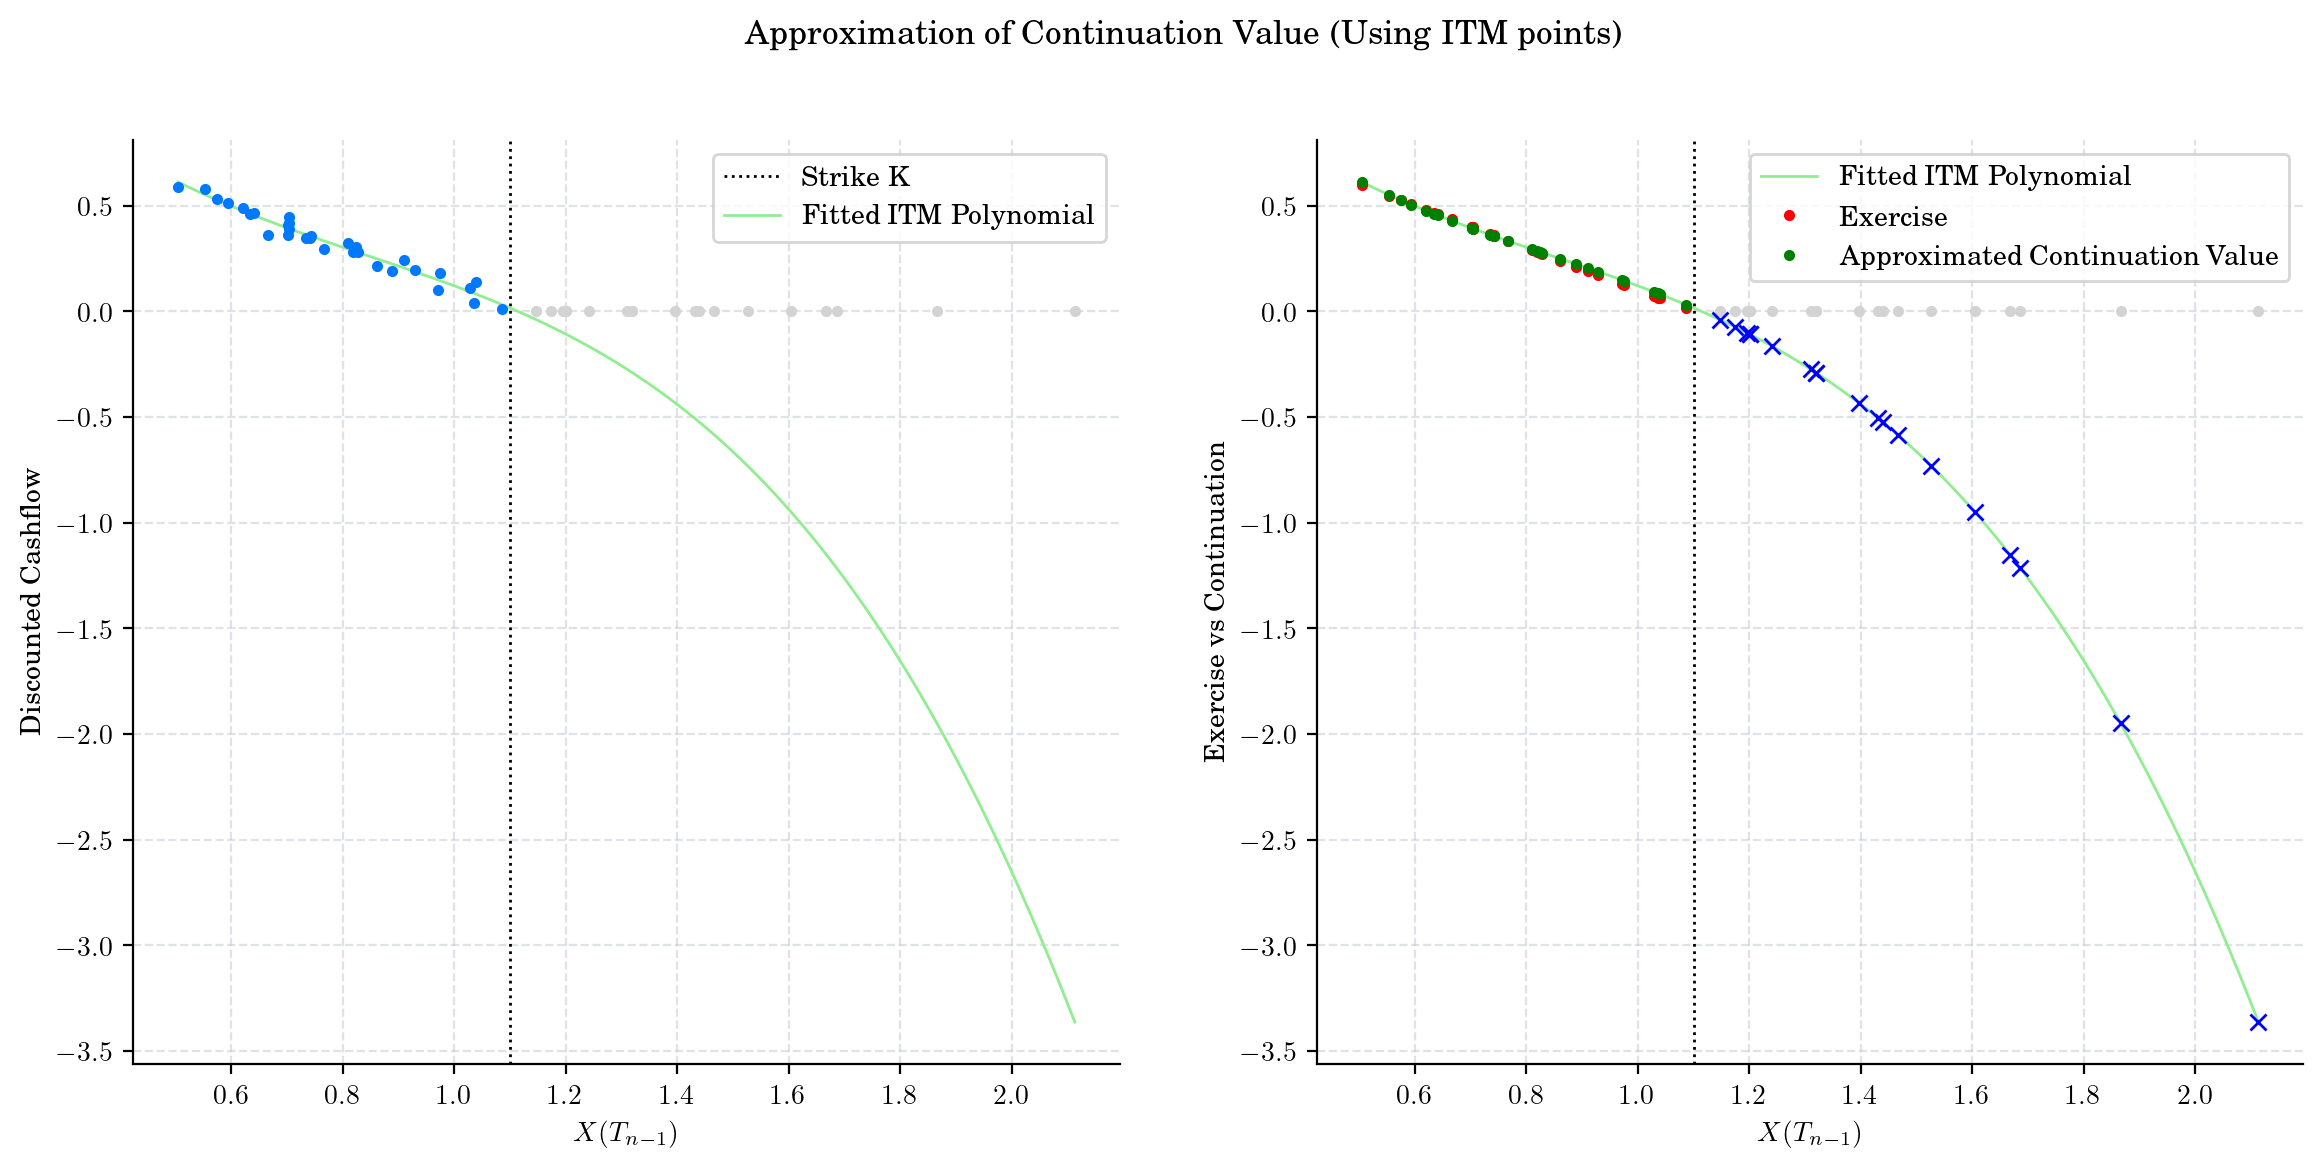

Polynomial([ 0.30724835, -0.26004336,  0.01463507, -0.02986435], domain=[0.5043643 , 1.08539069], window=[-1.,  1.], symbol='x')

In [12]:
cashflow = np.exp(-r * (times[-2] - times[-1])) * exercise_value(X[-1, :]) 
x = X[-2, :]
exercise = exercise_value(x) # recall payoff function
itm = exercise > 0 # use as index

fitted_itm = np.polynomial.Polynomial.fit(x[itm], cashflow[itm], 3)
continuation = fitted_itm(x)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(x[itm], cashflow[itm], ".", zorder=3)

axs[0].plot(x[~itm], cashflow[~itm], ".", zorder=3, color="lightgray")
axs[0].axvline(x=K, linestyle=":", color="black", label="Strike K")

aux = fitted.linspace()[0] 
axs[0].plot(aux, fitted_itm(aux), label="Fitted ITM Polynomial", color="lightgreen")

axs[1].plot(aux, fitted_itm(aux), label="Fitted ITM Polynomial", color="lightgreen")
axs[1].plot(x[itm], exercise[itm], ".", color="red", label="Exercise")
axs[1].plot(x[itm], continuation[itm], ".", color="green", label="Approximated Continuation Value")

axs[1].axvline(x=K, linestyle=":", color="black")

axs[1].plot(x[~itm], exercise[~itm], ".", color="lightgray")
axs[1].plot(x[~itm], fitted_itm(x[~itm]), "x", color="blue")

axs[0].set_xlabel("$X(T_{n-1})$")
axs[0].set_ylabel("Discounted Cashflow")

axs[1].set_xlabel("$X(T_{n-1})$")
axs[1].set_ylabel("Exercise vs Continuation")

fig.suptitle("Approximation of Continuation Value (Using ITM points)")
axs[0].legend()
axs[1].legend()
plt.show()
fitted_itm # return equation

### Iterating Backwards in Time
- Starting at expiry (terminal node) $T = t_n$
- At expiry $T$, the payoff is known: $U(t_n) = Y(t_n) = [K- S_{t_n}]^+$.
- At time $t_{n-1}$, we need to decide if to exercise or not to exercise, based on:
    $$ U(t_{n-1}) = \max\{ Y(t_{n-1}, \, C(t_{n-1}) \} $$

    where $C(t_{n-1}) \} = e^{-r (t_n - t_{n-1})}\mathbb{E}[U(t_n) \mid \mathcal{F}_{n-1}] $ and 
    $ Y(t_{n-1}) = [K- S_{t_{n-1}}]^+ $.
- Notice that **if** the holder does not exercise, then the option behaves likes an European (the exercise decision has to be made in the next step and there is no early exit choice, so exercise at expiry) over the period $ [t_n, t_{n-1}]$. Thus, we can discount the value $U(t_n)$ and hence obtaining 
    $$ \textrm{Discounted Cashflow} = V(t_{n-1}, t_n) = e^{-r(t_n - t_{n-1})} [K-S_{t_n}]^+.$$

In [13]:
# Moving step-by-step on each path  backwards
intermediate_results = []
cashflow = exercise_value(X[-1, :])

# Loop backwards in time
for i in reversed(range(1, X.shape[0] -1)):
    # One step discount factor, equidistant grid spacing
    df = np.exp(-r * (times[i+1] - times[i]))
    # Discounted cashflows
    cashflow = cashflow * df 
    # Stock price
    x = X[i, :]
    # Exercise value, at time t=i
    exercise = exercise_value(x)
    # Index ITM paths
    itm = exercise > 0
    # Fit polynomial to estimate continuation value
    fitted = np.polynomial.Polynomial.fit(x[itm], cashflow[itm], 3) # degree 3
    # Estimate continuation value, at time t=i
    continuation = fitted(x) 
    # Index where Exercise is optimal
    ex_idx = itm & (exercise > continuation)
    # Update cashflow with early exercises
    cashflow[ex_idx] = exercise[ex_idx]

    intermediate_results.append((cashflow, x, fitted, continuation, exercise, ex_idx))

# Define plotting approximation
def plot_approx_n(n_steps, ax):
    cashflow, x, fitted, continuation, exercise, ex_idx = intermediate_results[n_steps]
    fitted_x, fitted_y = fitted.linspace()
    ax.axvline(x=K, linestyle=":", color="black", label="K")
    ax.plot(x[ex_idx], exercise[ex_idx], ".", color="red", zorder=5, label="Optimal to Exercise")
    ax.plot(x[~ex_idx], exercise[~ex_idx], ".", color="green", zorder=4, label="Optimal to Continue")
    ax.plot(fitted_x, fitted_y, zorder=2, color="lightgreen", label="Approximated Continuation Value")
    _x = np.linspace(np.min(x), np.max(x))
    ax.plot(_x, fitted(_x), "--", color="lightgray", zorder=1)
    ax.legend()

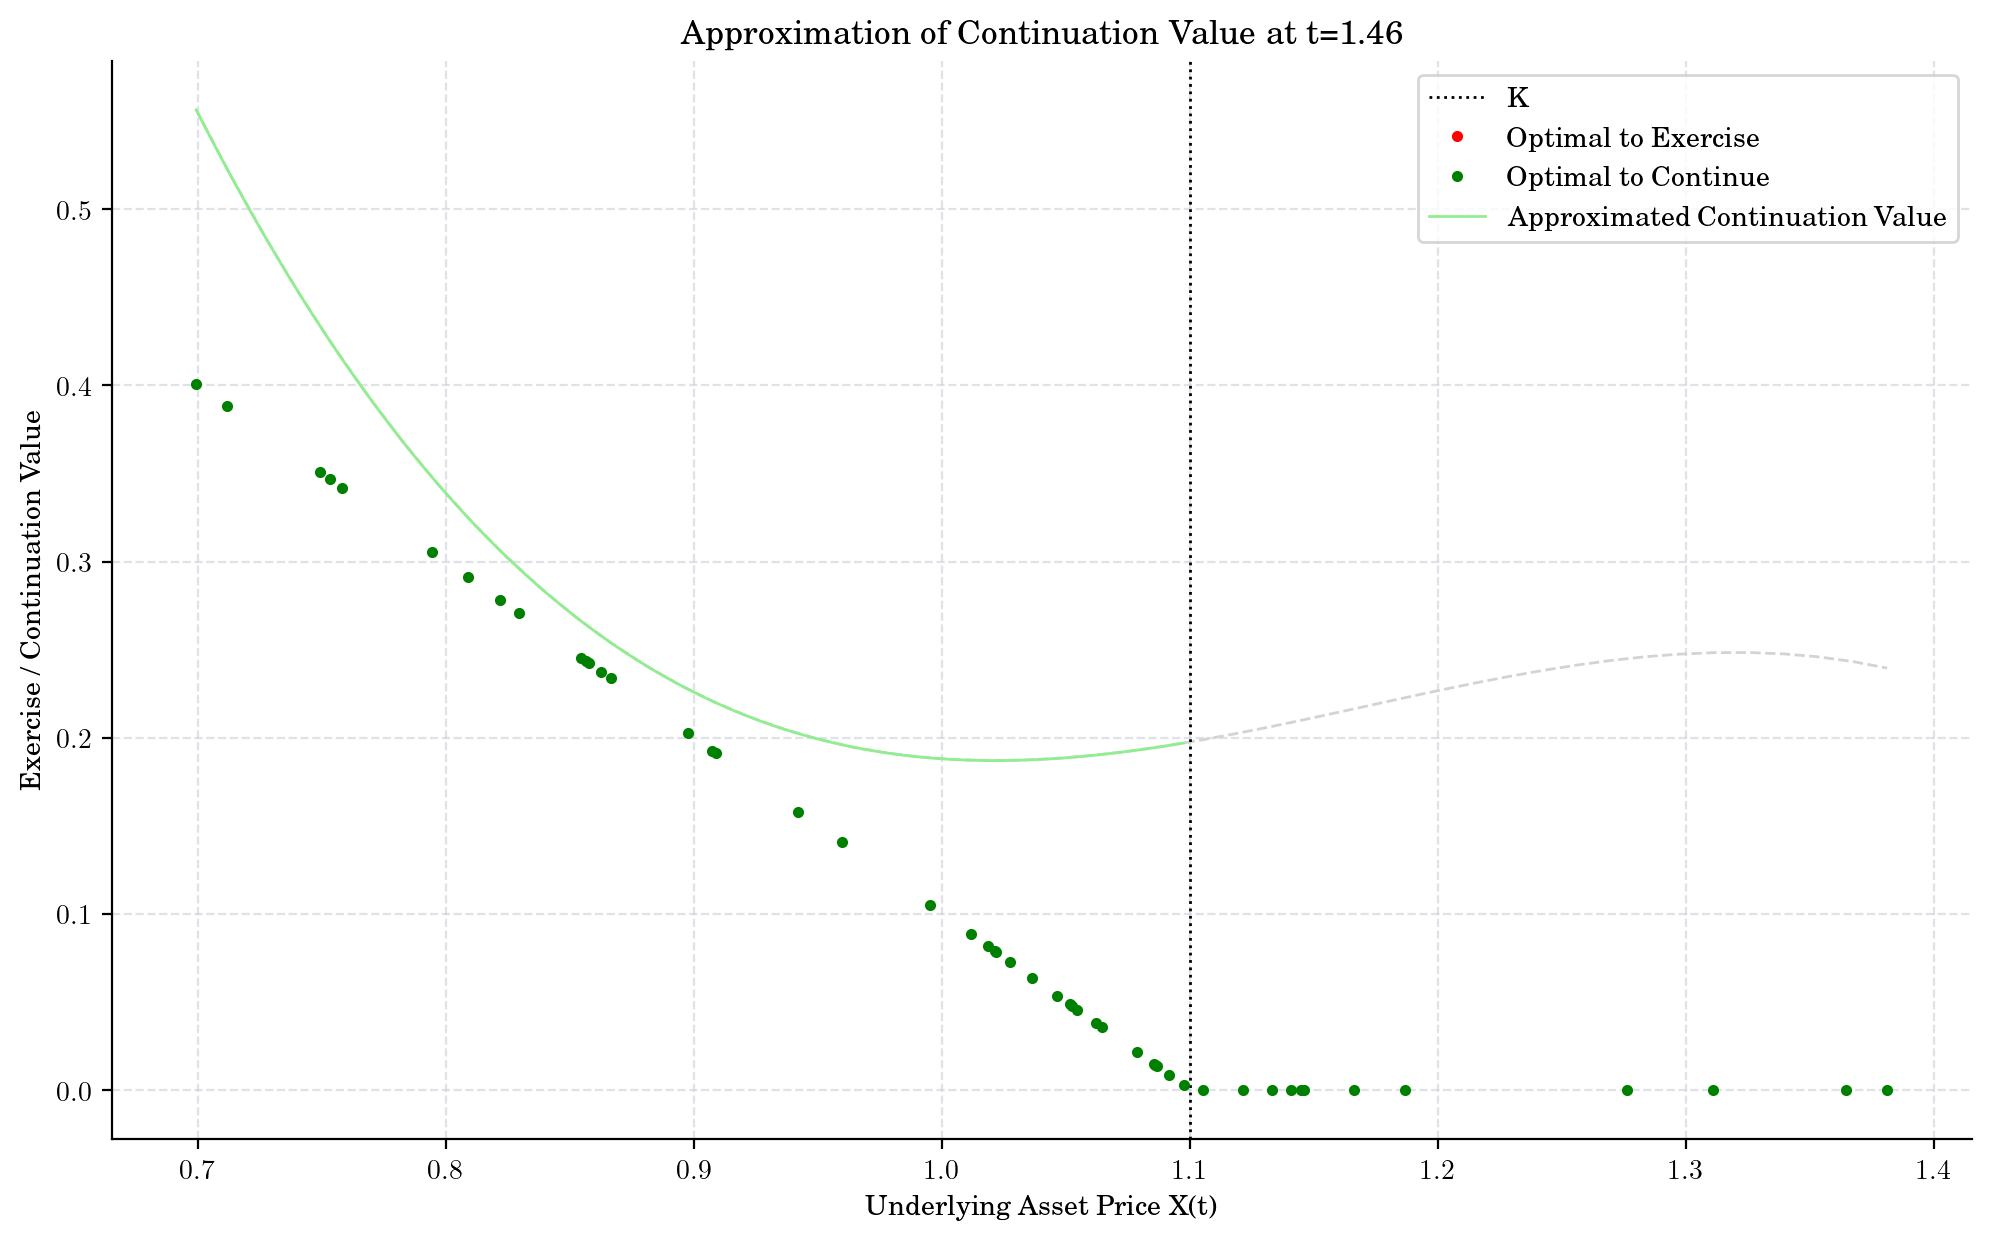

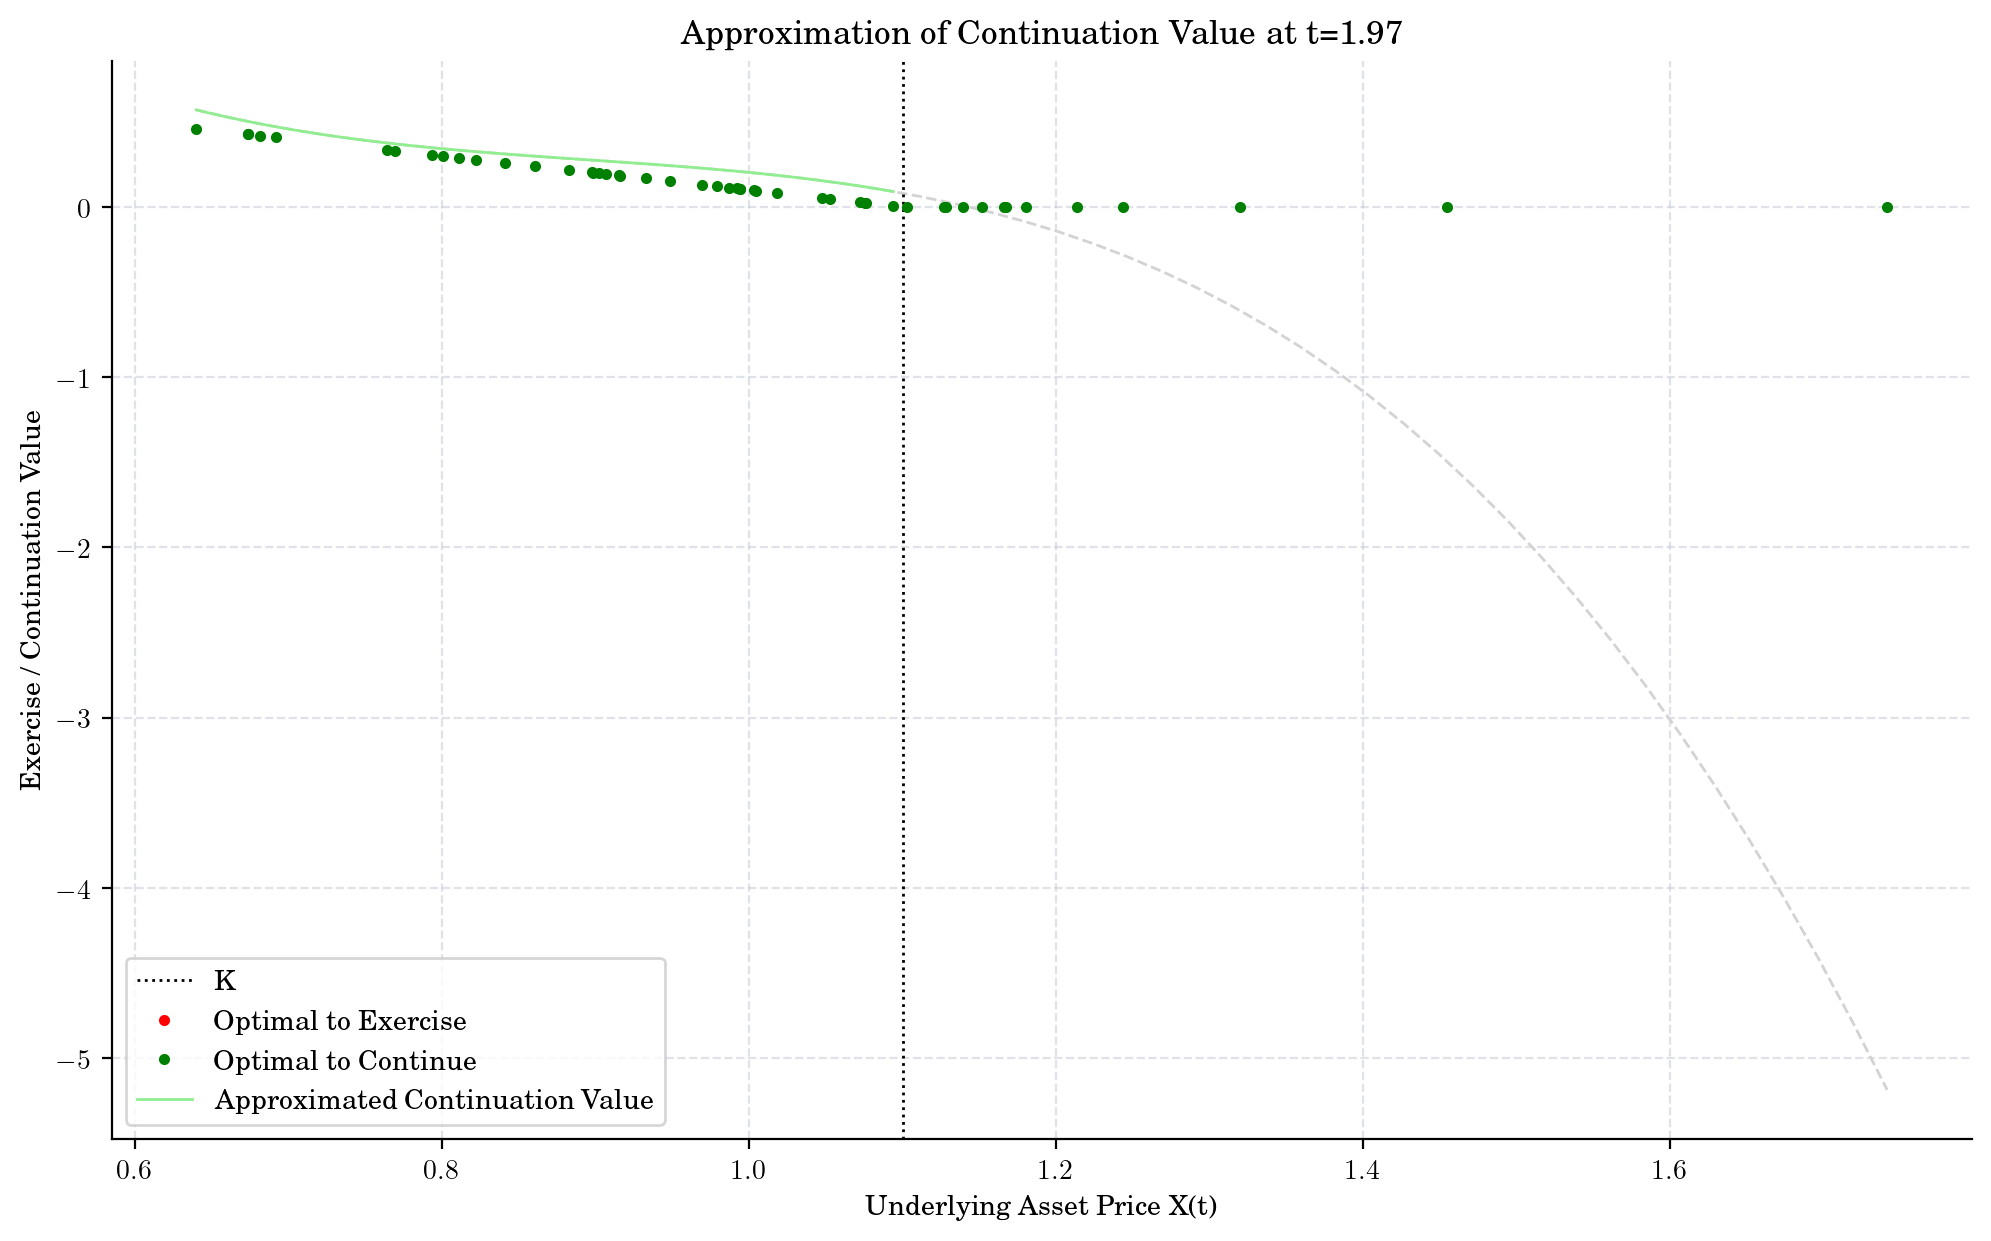

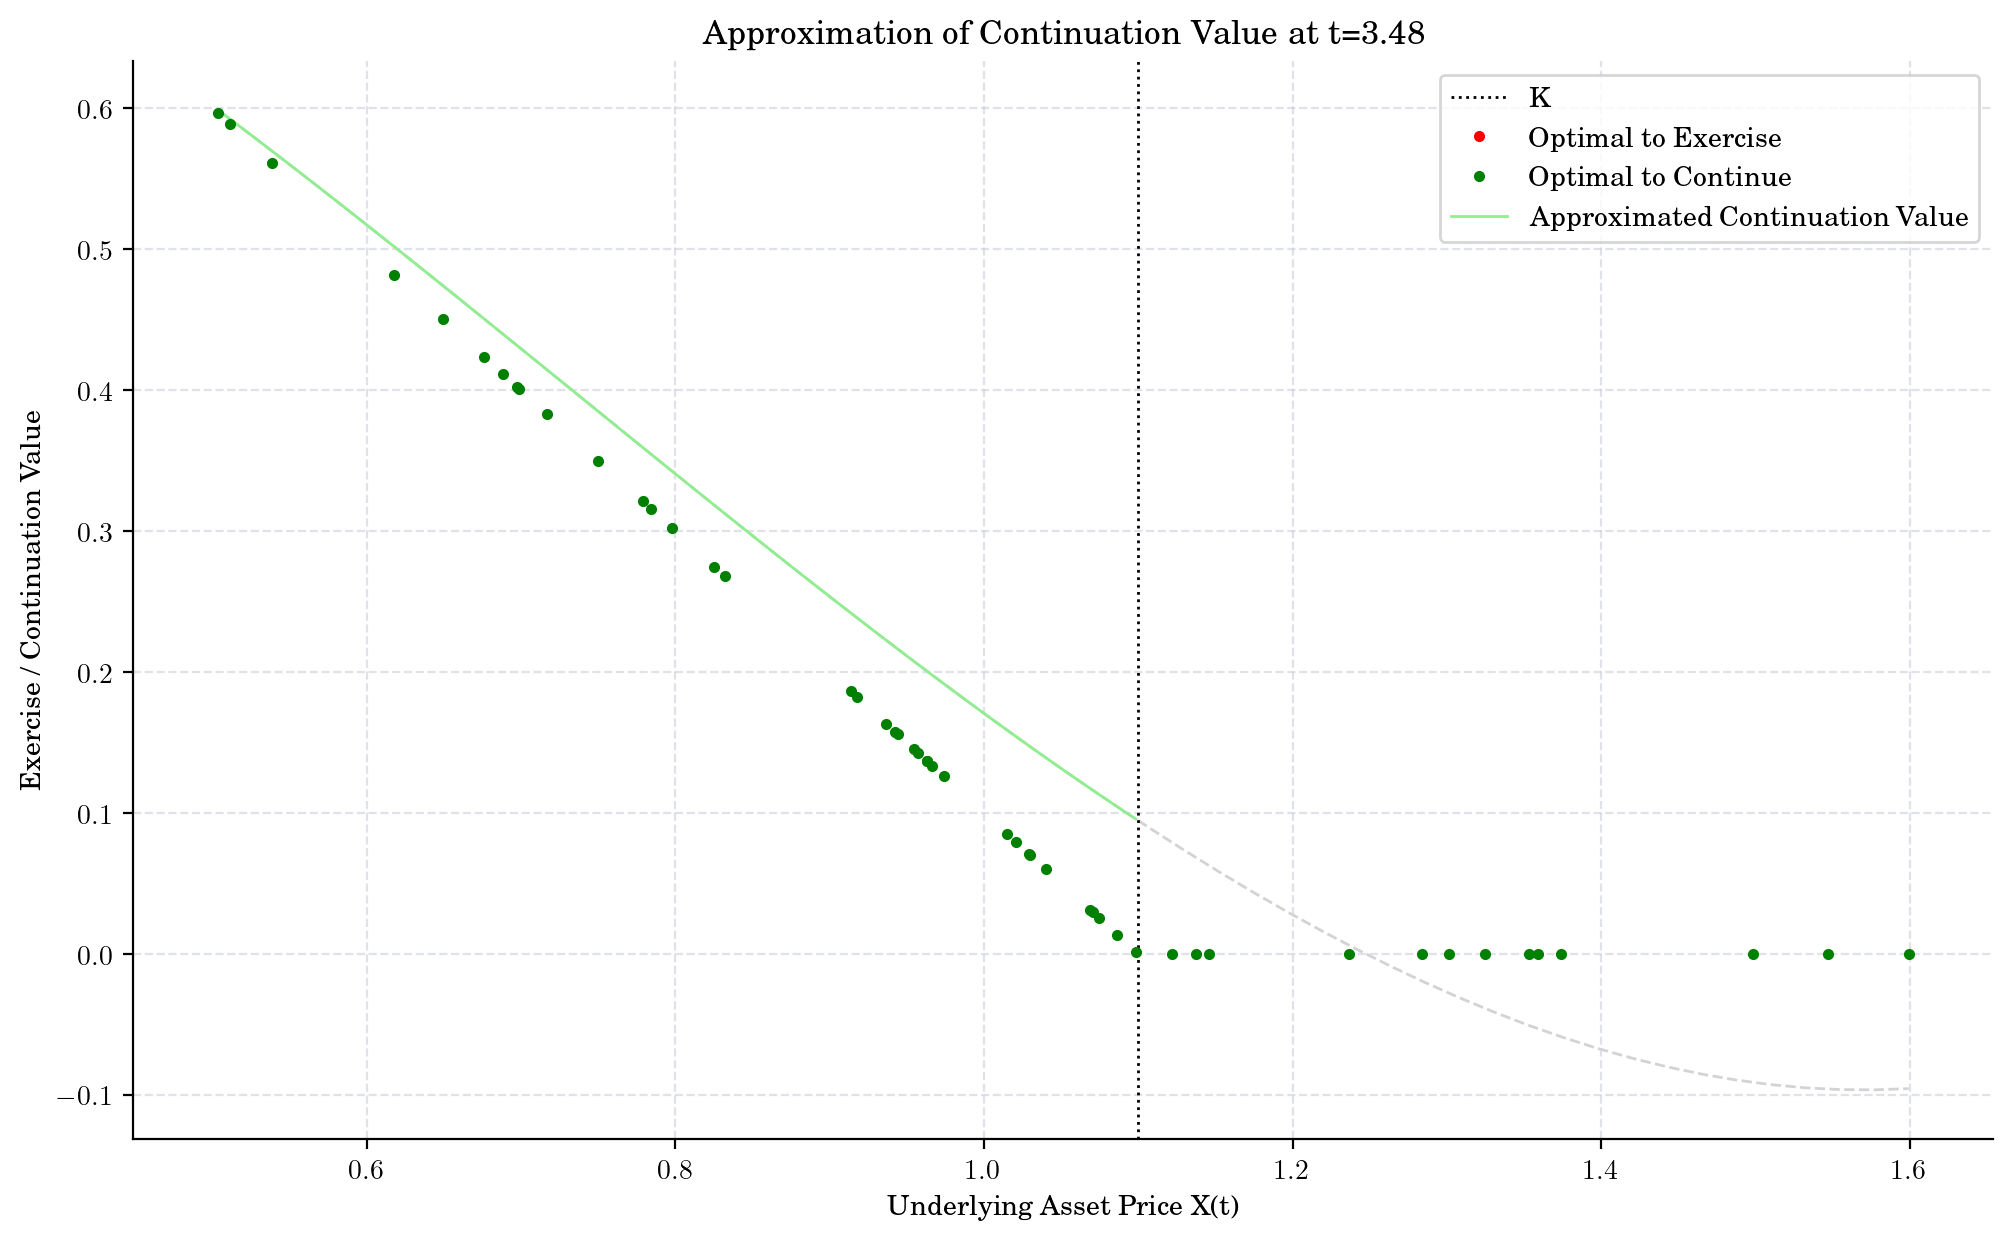

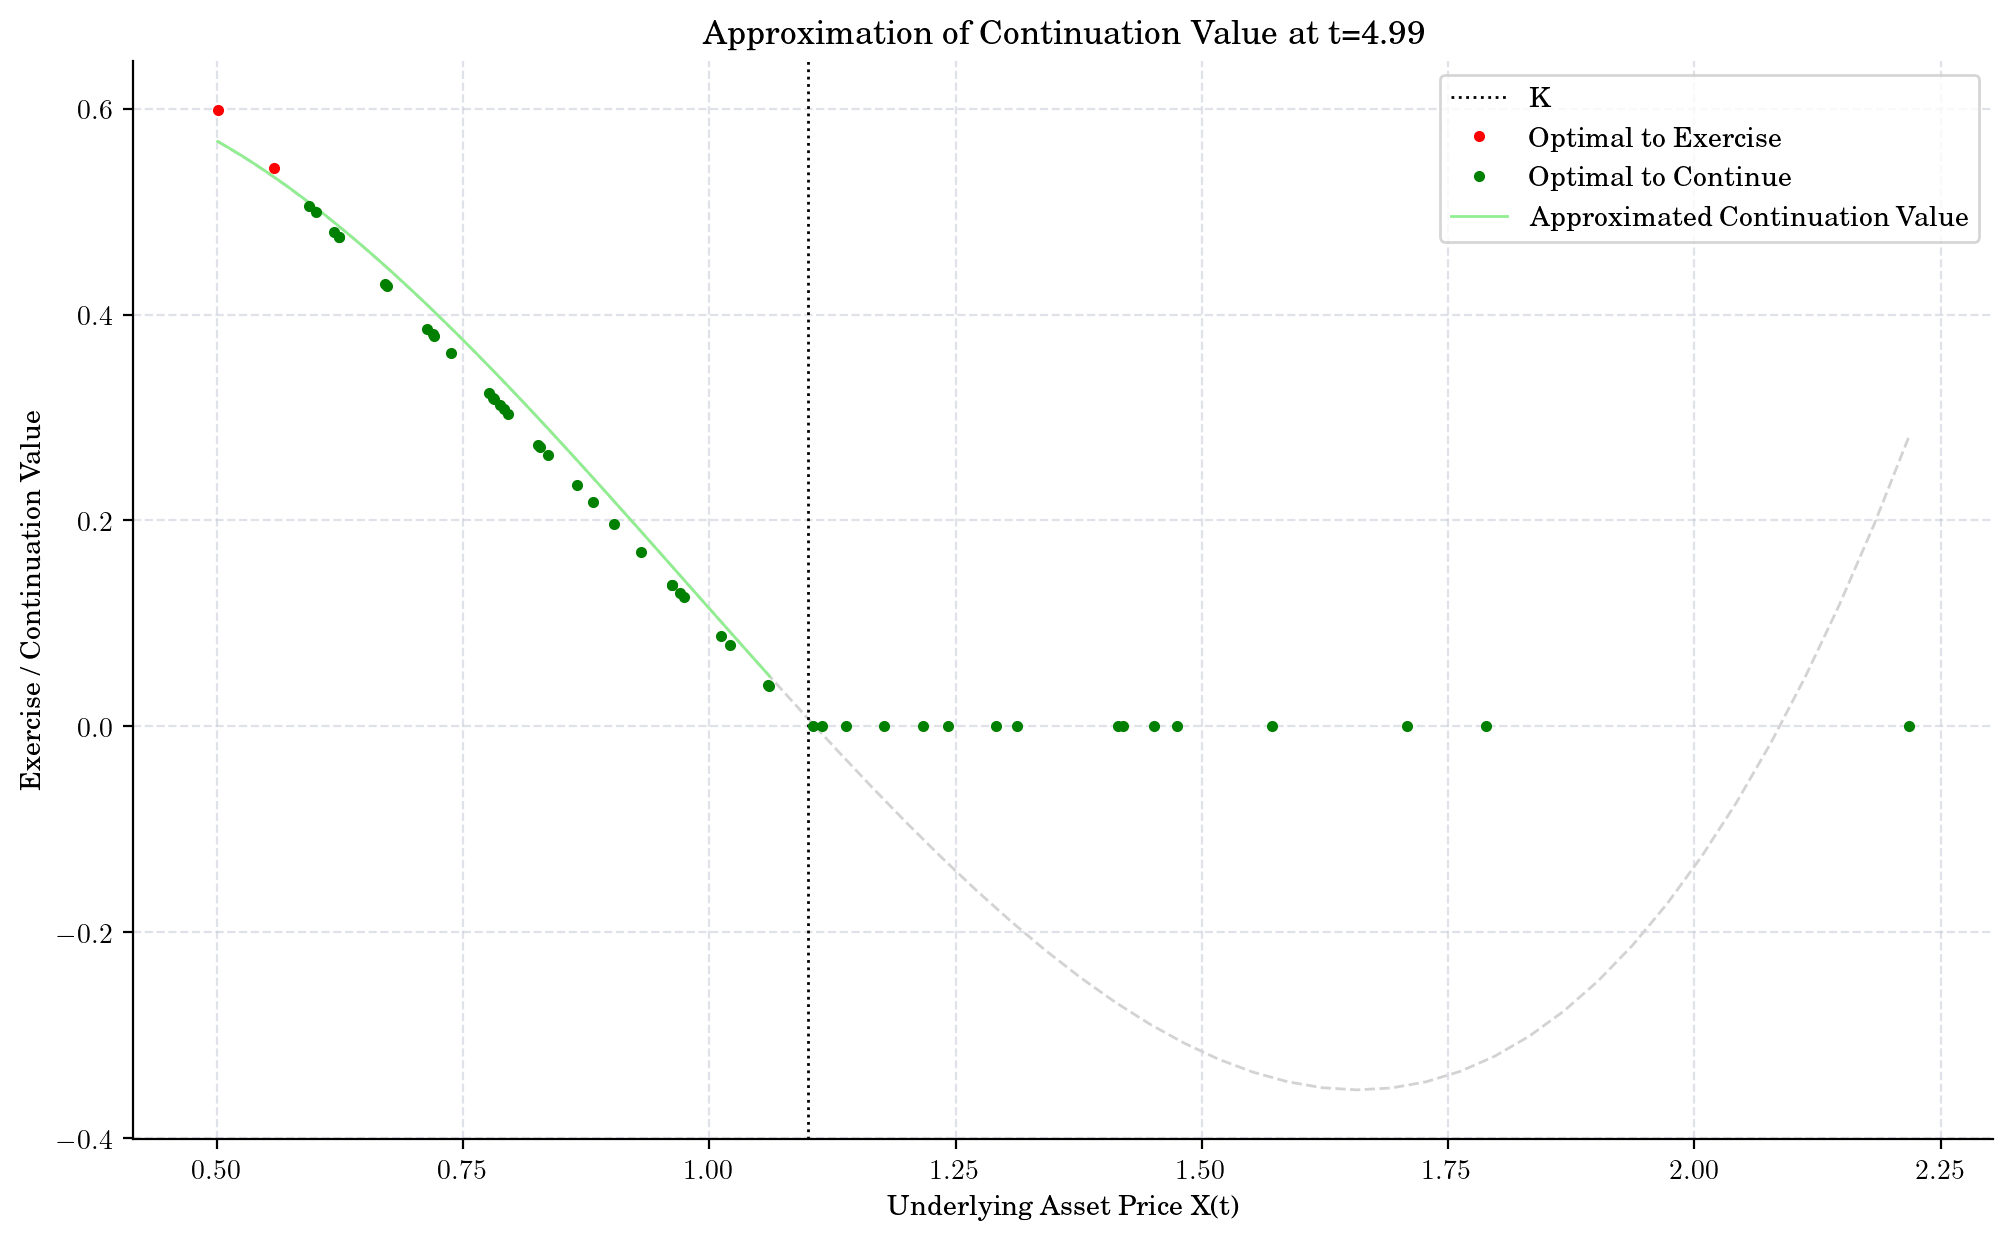

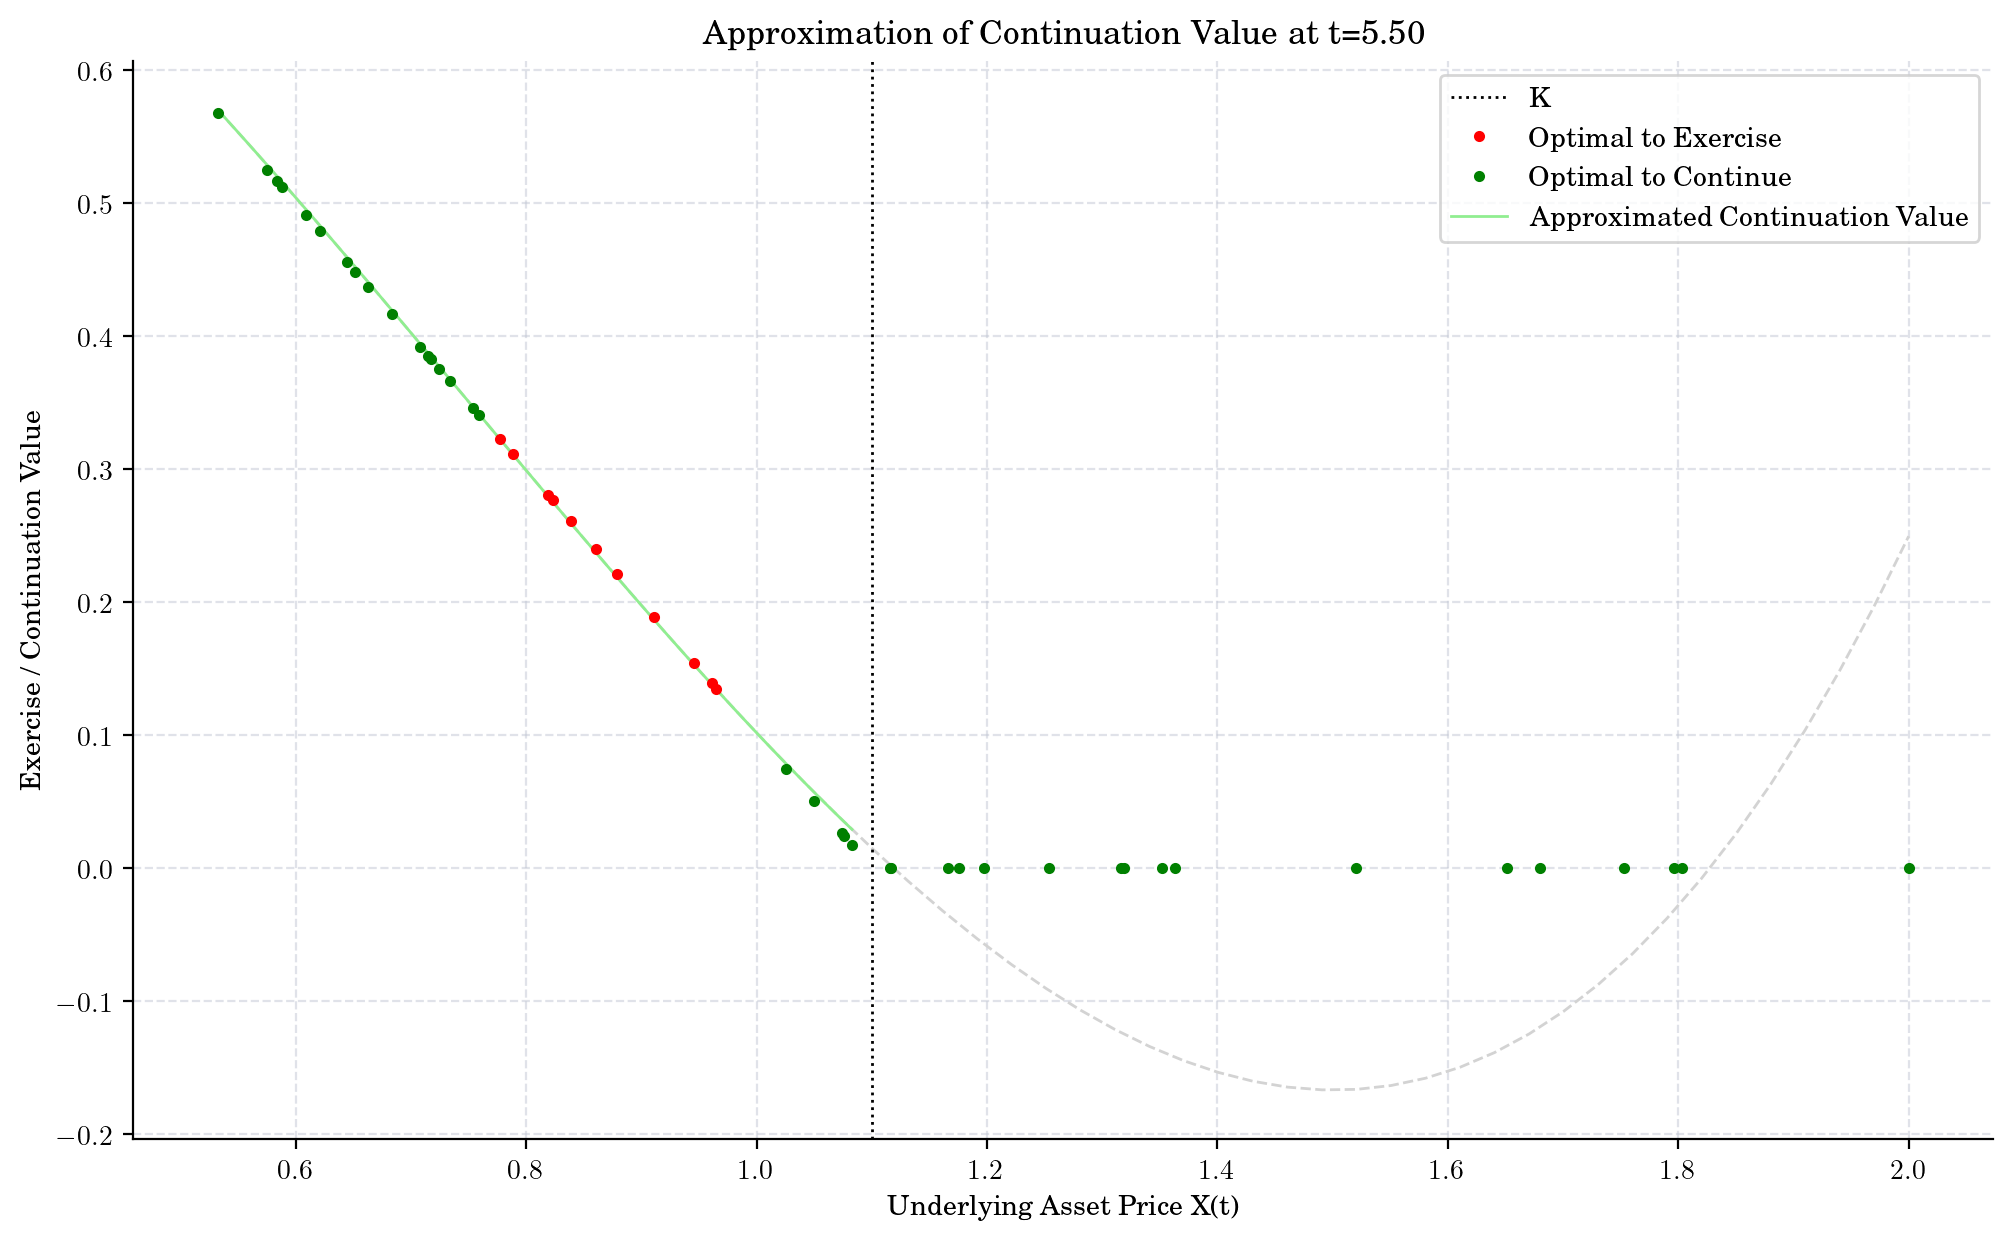

In [14]:
indices = [90, 80, 50, 20, 10]
t = times
for n, i in enumerate(indices):
    fig, ax = plt.subplots()
    plot_approx_n(i, ax)
    ax.set_title(f"Approximation of Continuation Value at t={t[-i-1]:0.2f}")
    plt.xlabel("Underlying Asset Price X(t)")
    plt.ylabel("Exercise / Continuation Value")
    plt.show()

What did we learn?

Now, let us go path by path and see if it will be optimal to exercise early.

In [15]:
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []

for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i-1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i-1])
        non_exercises.append(ex)

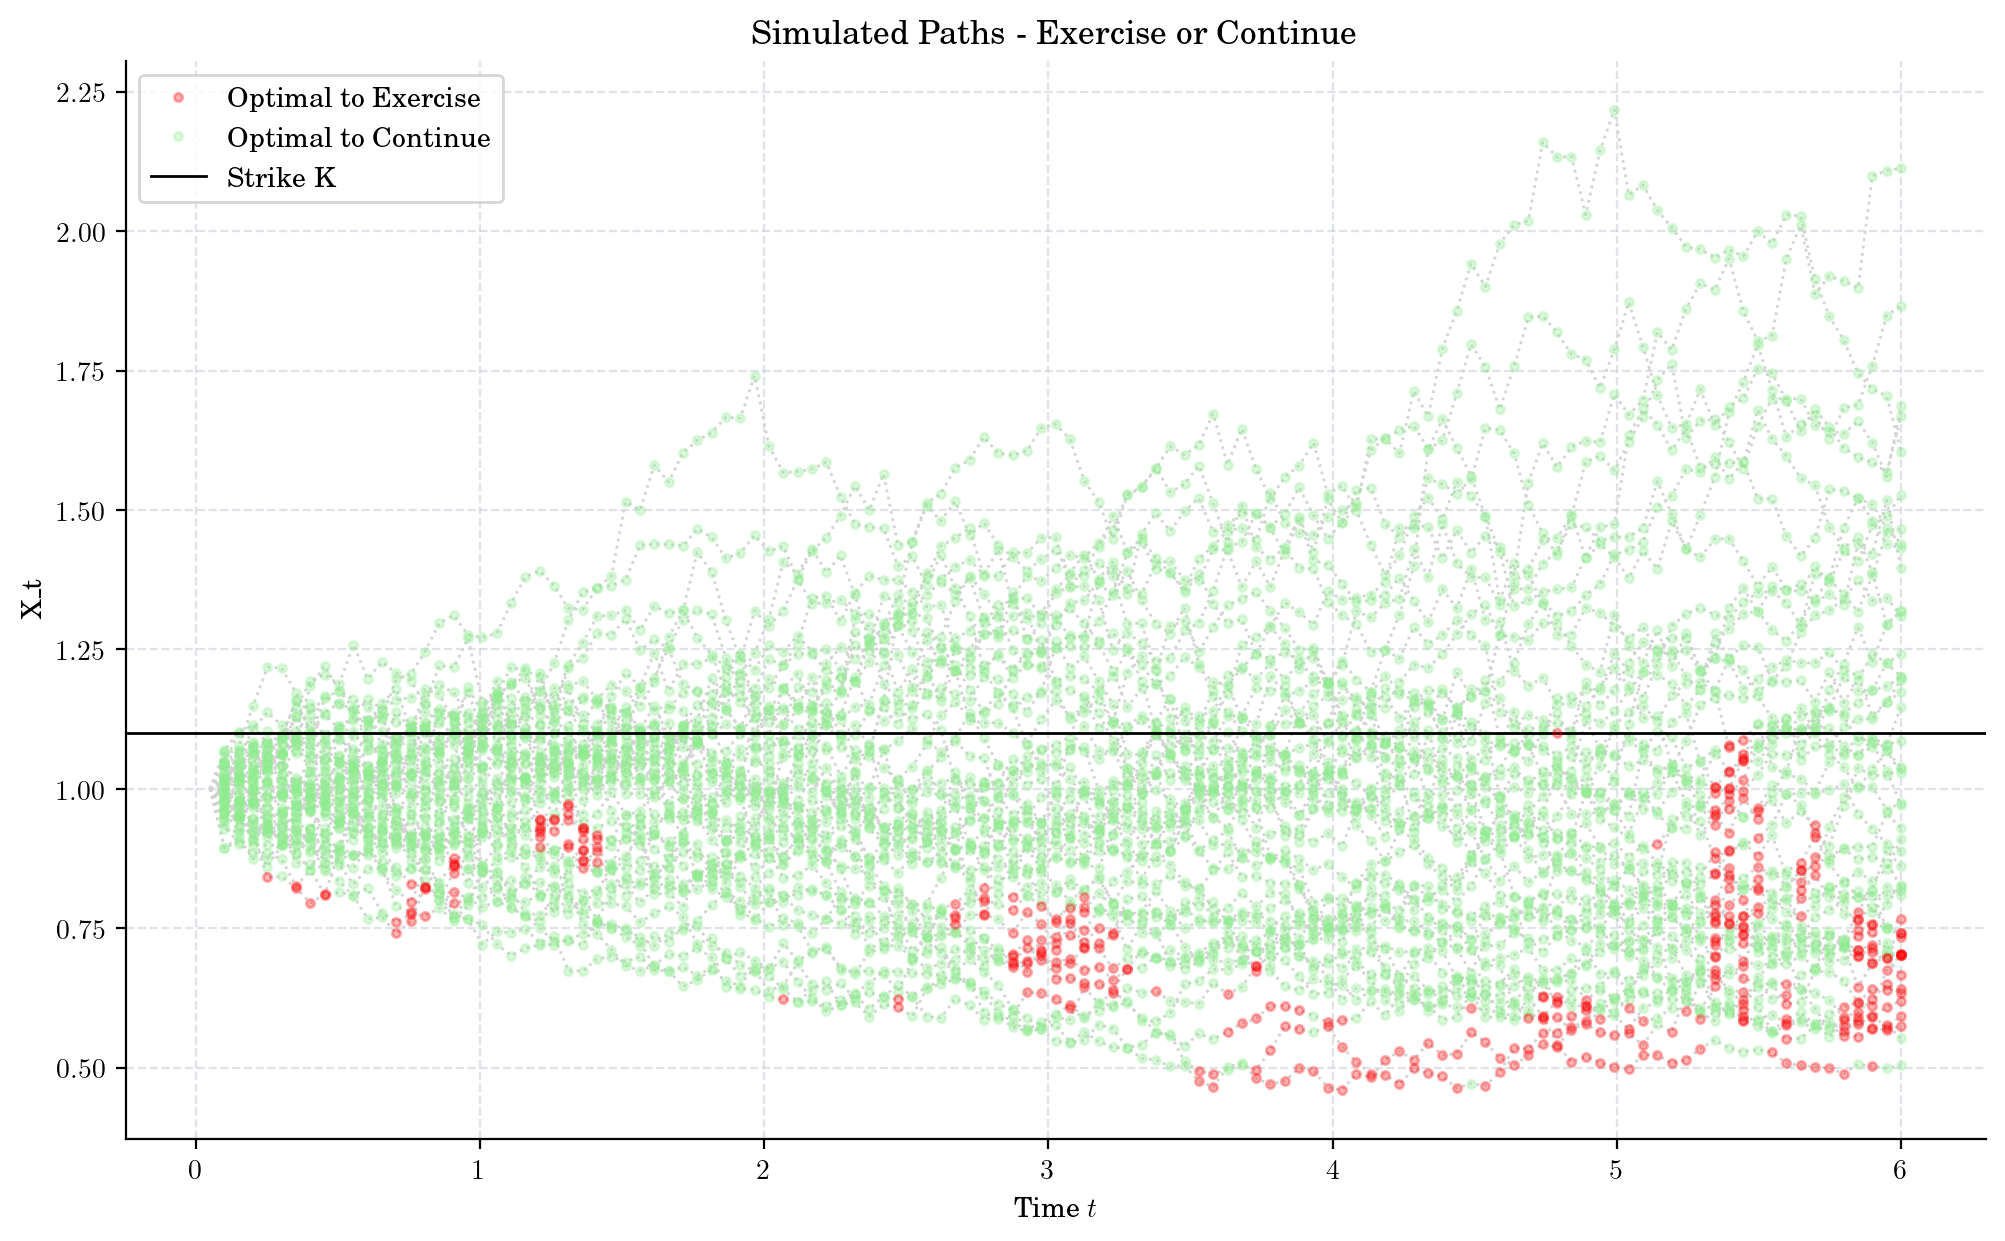

In [16]:
plt.figure()
for path in paths:
    plt.plot(times[1:], path[:-1], ":", color="lightgray", zorder=1)
plt.plot(exercise_times, exercises, ".", color="red", alpha=0.3, label="Optimal to Exercise", zorder=3)
plt.plot(non_exercise_times, non_exercises, ".", color="lightgreen", alpha=0.3, label="Optimal to Continue")
plt.axhline(y=K, linestyle="-", color="black", label="Strike K")
plt.legend()
plt.xlabel("Time $t$")
plt.ylabel("X_t")
plt.title("Simulated Paths - Exercise or Continue")
plt.show()

In [17]:
n_timesteps, n_paths = X.shape
first_exercise_idx = n_timesteps * np.ones(shape=(n_paths,), dtype="int")

for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        idx_now = (n_timesteps - i - 1) * np.ones(shape=(n_paths,), dtype="int")
        first_exercise_idx[ex_idx] = idx_now[ex_idx]

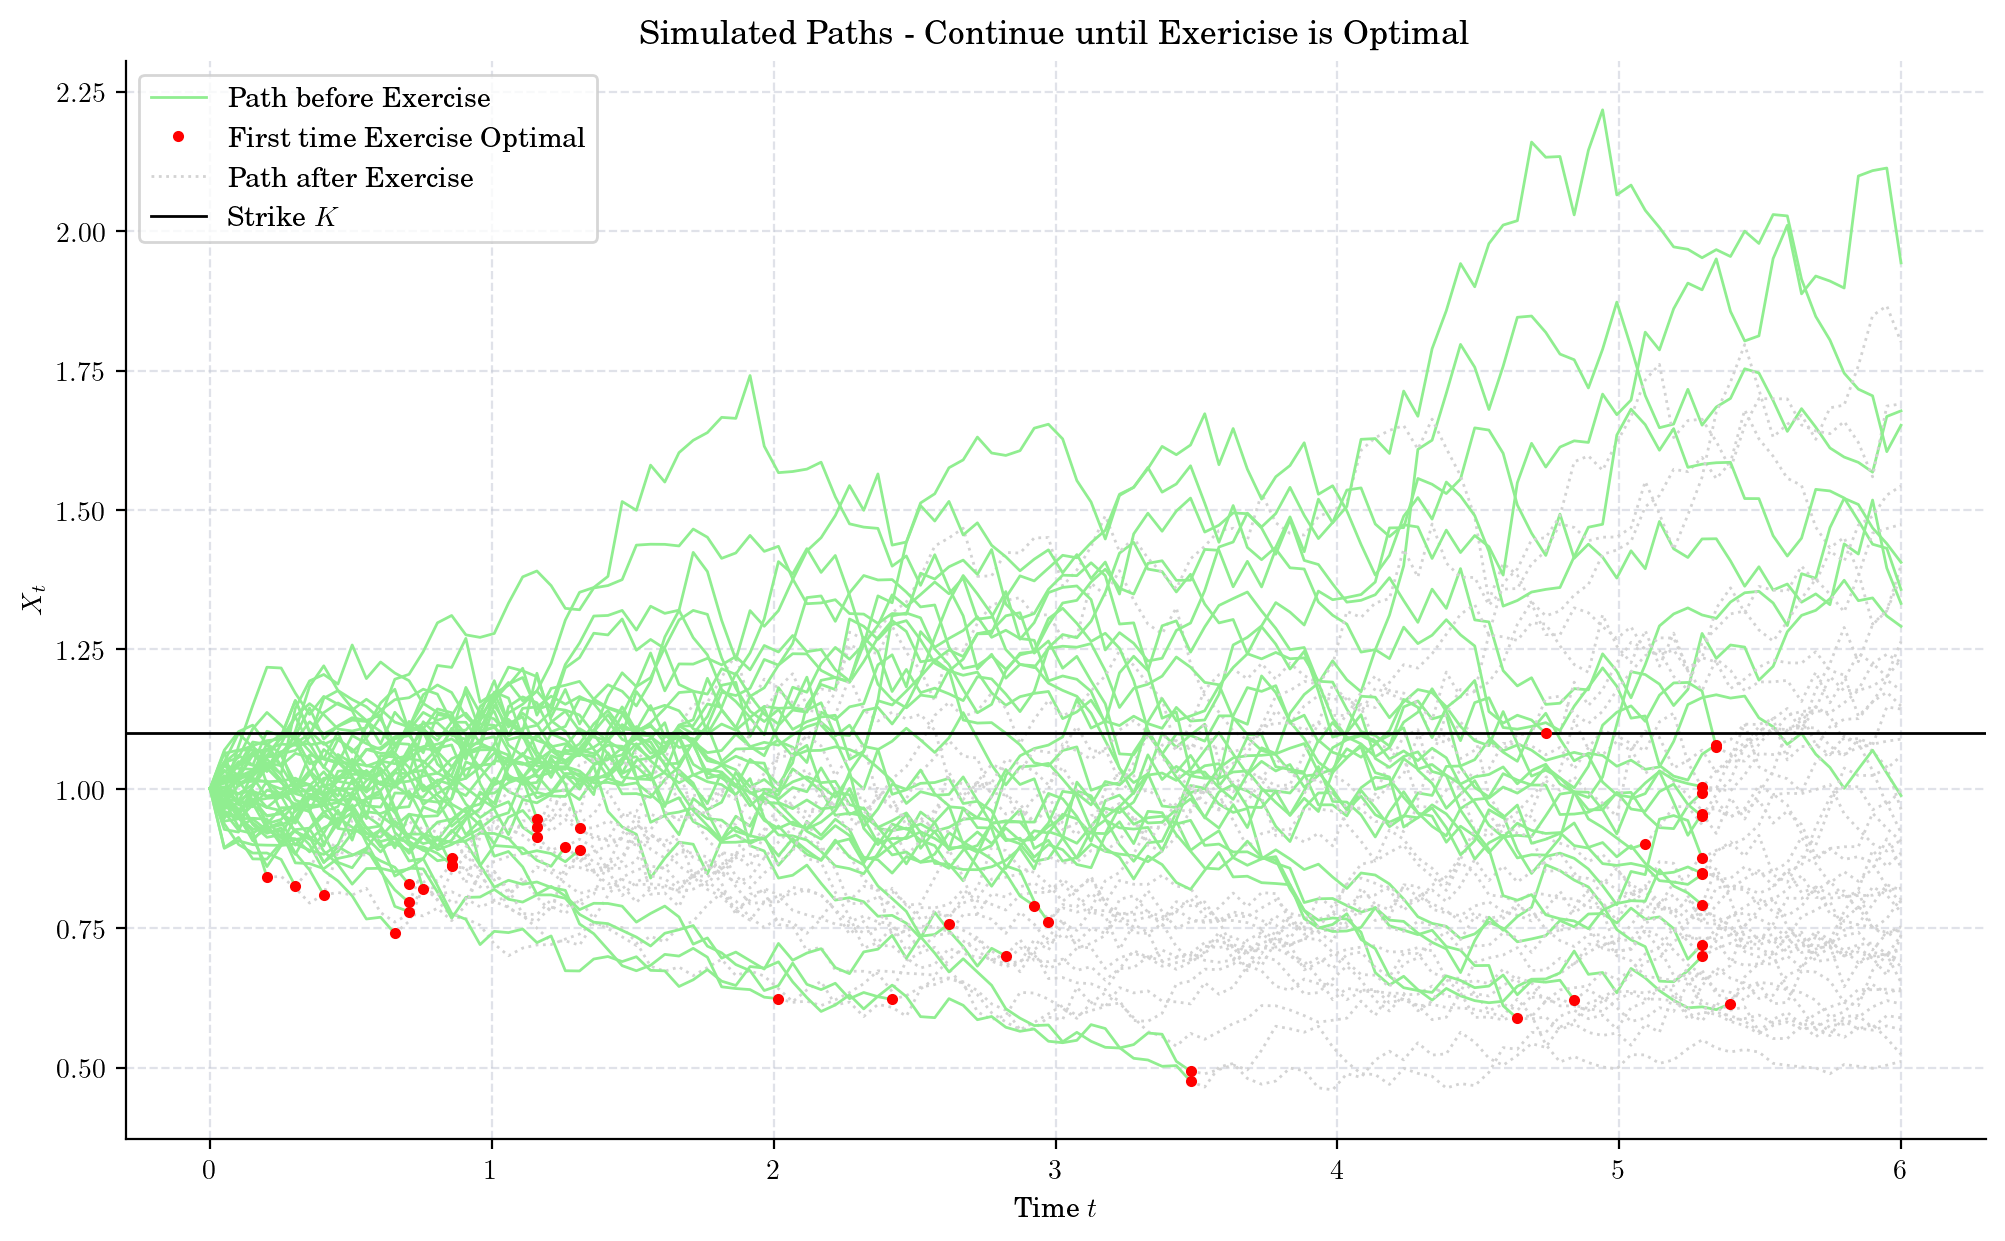

In [18]:
for idx, path in enumerate(paths):
    stop = first_exercise_idx[idx]
    # Split the path on if exercise
    (handle_path_before,) = plt.plot(times[:stop], path[:stop], color="lightgreen")
    (handle_path_stop,) = plt.plot(times[stop-1:], path[stop-1:], ":", color="lightgray")
    if stop < len(times):
        (handle_path_after,) = plt.plot(times[stop-1], path[stop-1], "r.", zorder=3)

strike_line = plt.axhline(y=K, linestyle="-", color="black")
plt.xlabel("Time $t$")
plt.ylabel("$X_t$")
plt.title("Simulated Paths - Continue until Exericise is Optimal")
plt.legend([handle_path_before, handle_path_after, handle_path_stop, strike_line],
            ["Path before Exercise", "First time Exercise Optimal", "Path after Exercise", "Strike $K$"])
plt.show()

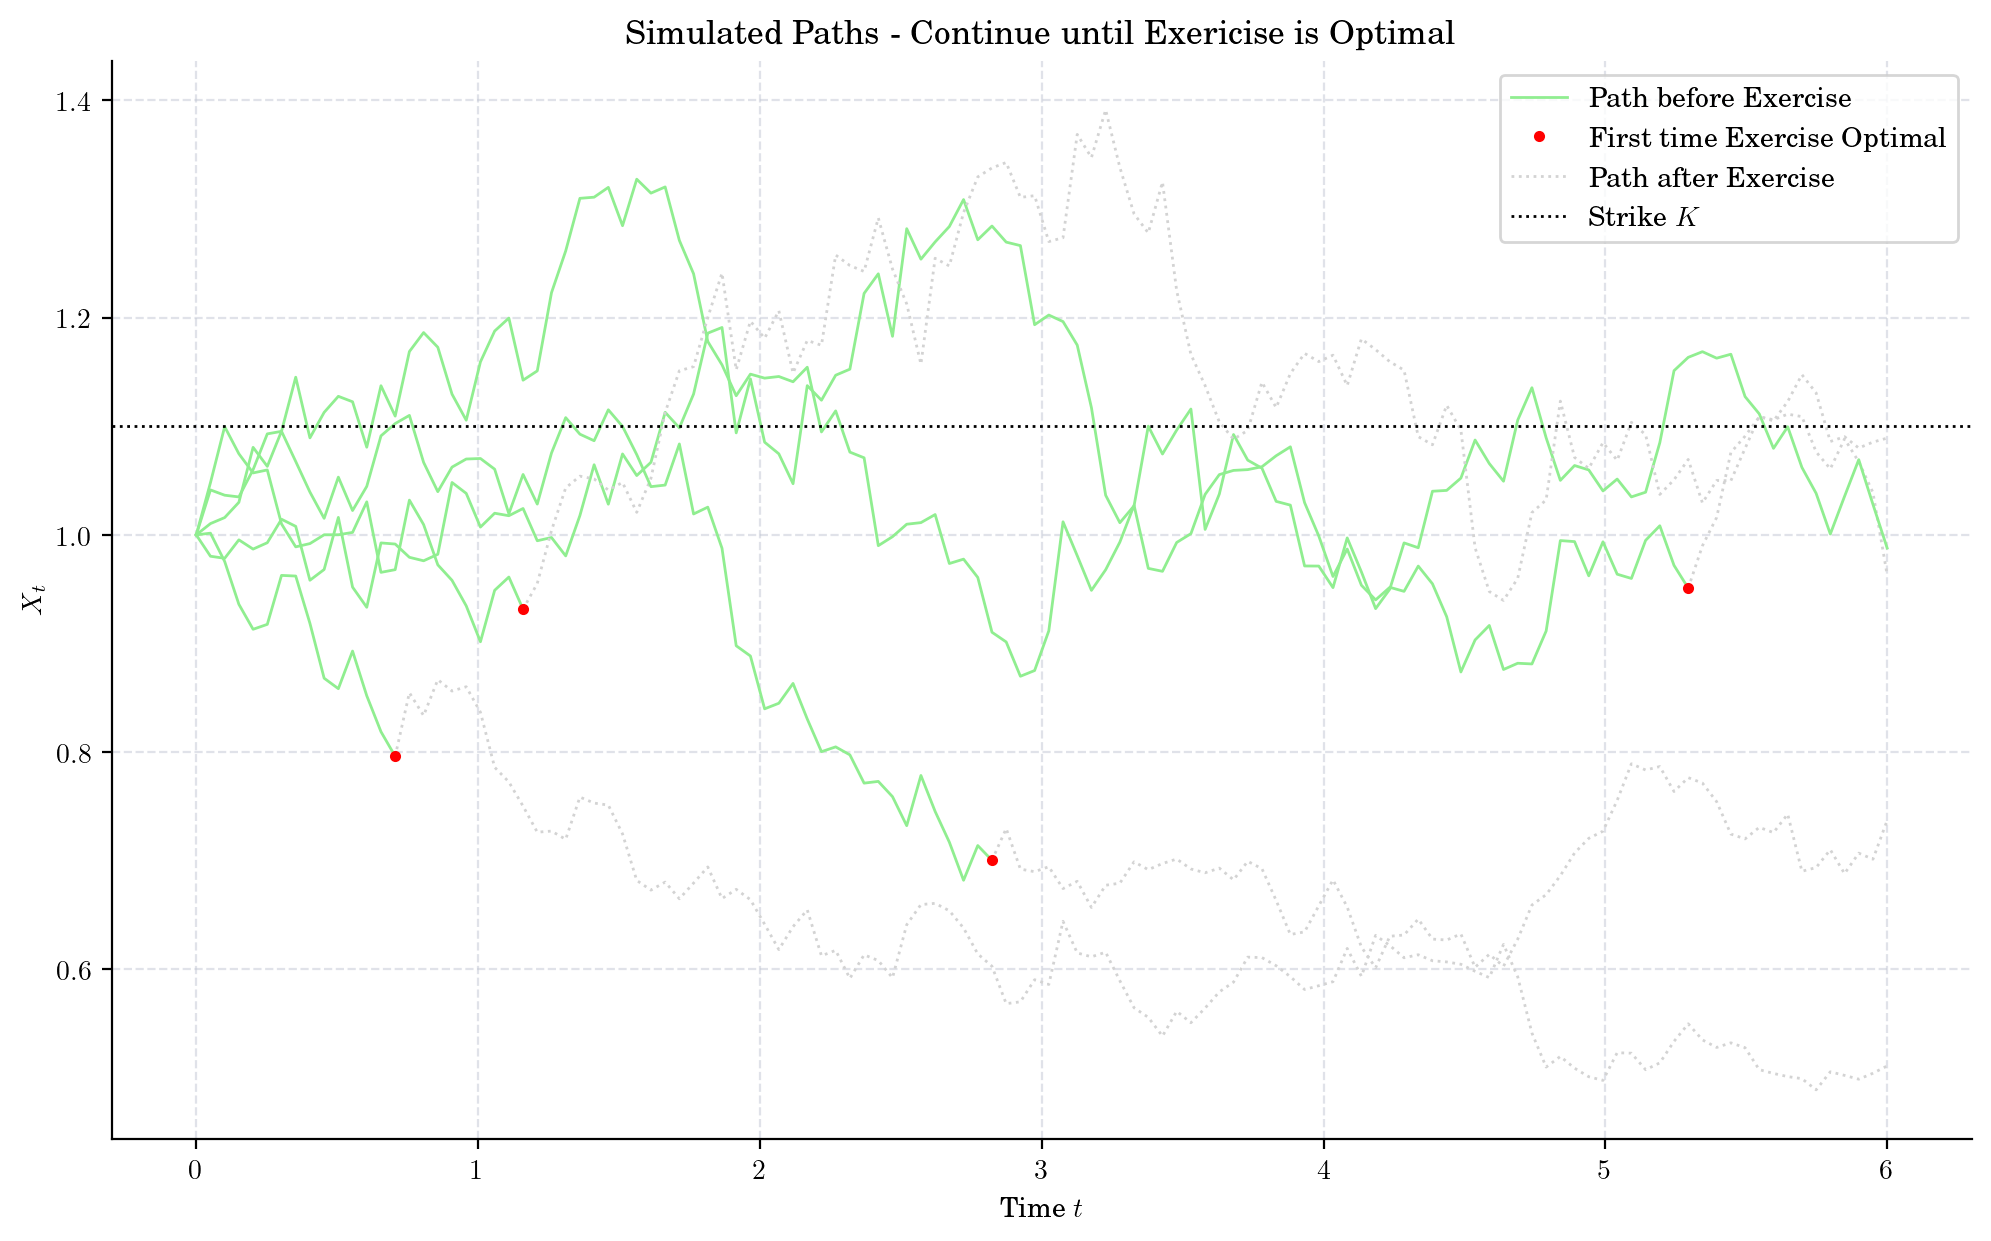

In [19]:
for idx, path in enumerate(paths[:5]):
    stop = first_exercise_idx[idx]
    (handle_path_before,) = plt.plot(times[:stop], path[:stop], color="lightgreen")
    (handle_path_stop,) = plt.plot(times[stop-1:], path[stop-1:], ':', color="lightgrey")
    if stop < len(times):
        (handle_path_after,) = plt.plot(times[stop-1], path[stop-1], 'r.', zorder=3)
        
strike_line = plt.axhline(y=K, linestyle=':', color="black")
plt.xlabel("Time $t$")
plt.ylabel("$X_t$")
plt.title("Simulated Paths - Continue until Exericise is Optimal")
plt.legend([handle_path_before, handle_path_after, handle_path_stop, strike_line],
            ["Path before Exercise", "First time Exercise Optimal", "Path after Exercise", "Strike $K$"])
plt.show()